# Projet Adomos

Objectif : Outil de simulation pour le financement et la fiscalité d'un produit immobilier dans le neuf.

Introduction : 

L'outil doit appréhender au mieux l'analyse d'un investisseur et d'un bien et de faire le matching entre les deux parties :

- faudra créer des scénarios "théoriques" pour avoir une estimation du profil de l'investisseur et de sa capacité d'achat
- à partir de ce profil, le modèle devra proposer un (ou des) scénarios optimales (optimisation du loyer, de régime, ...)
- enfin la simulation


Utilisation de notebook :

- meilleur compréhension si user intérargit 
- fonction python apisable en quelques minutes
- adapbilité si besoin futur évolue

Description :

- Phase 1 : Installation des outils nécessaires pour le projet et importation des libraries
- Phase 2 : Mise en place des hypothèses
- Phase 3 : Fonction servant à l'utilisateur (côté front) pour calculer la capacité d'achat théorique
- Phase 4 : Fonction utilitaire pour la phase 5 
- Phase 5 : Fonction pour "l'API" et la simulation
- Phase 6 : Fonction pour render sur jupyter notebook la simulation
- Phase 7 : Execution de la simulation

Pour lancer le projet, il faut choisir sur la barre de navigation Runtime > Run all  et aller sur la phase 7

## Phase 1 - Intallation:

In [116]:
!pip install numpy_financial
!pip install OpenFisca-Core
!pip install OpenFisca-France
#!pip install voila
#!jupyter labextension install @voila-dashboards/jupyterlab-preview

import ipywidgets as widgets
from IPython.display import display, clear_output
import pandas as pd
import numpy_financial as npf
import sys
import asyncio
from time import time
from threading import Timer
import numpy as np 
import json
import requests
import ast
import requests
import urllib.parse
import json
from tqdm.notebook import tqdm
import httpx
import trio
import sys
from selenium import webdriver
from selenium.common.exceptions import NoSuchElementException
import matplotlib.pyplot as plt
# if using a Jupyter notebook, include:
%matplotlib inline

def throttle(wait):
    """ Decorator that prevents a function from being called
        more than once every wait period. """
    def decorator(fn):
        time_of_last_call = 0
        scheduled, timer = False, None
        new_args, new_kwargs = None, None
        def throttled(*args, **kwargs):
            nonlocal new_args, new_kwargs, time_of_last_call, scheduled, timer
            def call_it():
                nonlocal new_args, new_kwargs, time_of_last_call, scheduled, timer
                time_of_last_call = time()
                fn(*new_args, **new_kwargs)
                scheduled = False
            time_since_last_call = time() - time_of_last_call
            new_args, new_kwargs = args, kwargs
            if not scheduled:
                scheduled = True
                new_wait = max(0, wait - time_since_last_call)
                timer = Timer(new_wait, call_it)
                timer.start()
        return throttled
    return decorator


#Openfisca_library

from pprint import pprint  # data pretty printer

from openfisca_core.simulation_builder import SimulationBuilder
from openfisca_france import FranceTaxBenefitSystem

tax_benefit_system = FranceTaxBenefitSystem()

You should consider upgrading via the '/usr/local/opt/python@3.8/bin/python3.8 -m pip install --upgrade pip' command.
You should consider upgrading via the '/usr/local/opt/python@3.8/bin/python3.8 -m pip install --upgrade pip' command.
You should consider upgrading via the '/usr/local/opt/python@3.8/bin/python3.8 -m pip install --upgrade pip' command.


## Phase 2 - Hypothèse :

In [435]:
#Général
location_prixsurface_minimum = 144
location_prixsurface_maximum = 288
location_prixsurface_moyen = 192
#https://www.seloger.com/prix-de-l-immo/location/pays/france.htm

inflation = 0.02 
plafond_mensuel_pinel_2022 = {"A bis": 17.62, "A": 13.09, "B1": 10.55, "B2": 9.17}

#Profil investisseur
revenus_mensuel = 0 #input user
credit_en_cours = 0 #input user

#Profil bien
destination_bien = "LO" #list: ["Résidence Locative", "Résidence à usage mixte", "Professionnel", "Résidence principal", "Résidence secondaire ou en vue de retraite"] #creditlogement.fr
departement_bien = "93" #à envoyer
ville_bien = 'Pierrefitte-sur-Seine' #à envoyer
nombre_lots_programme = "OneTo10"#list: [OneTo10,ElevenTo24,TwentyFiveTo99,OneHundredTo249,TwoFiftyTo499,FiveHundredOrMore]  #à ajouter
surface_annexe = 0 #à envoyer
surface_terrasse = 0 #à envoyer
surface_cave = 0 #à envoyer
loyer_decote = 0.125 #écart entre meublé et non meublé https://www.pap.fr/bailleur/location-vide-meuble/louer-vide-ou-meuble-quel-est-le-plus-rentable/a2074#:~:text=Location%20vide%20%3A%20des%20loyers%20moins%20%C3%A9lev%C3%A9s,-La%20fourniture%20de&text=A%20qualit%C3%A9%2C%20surface%20et%20emplacement,sera%20jamais%20deux%20fois%20sup%C3%A9rieur%20!
surface_studio = 28
surface_t1 = 45
max_loyer = 24000 #utiliser pour l'optimisation uniquement à affiner il faudrait que c'est valeur doit répresenter le loyer max par rapport à la surface recherchée


#Financement
nature_pret = "PBC" #prêt_bancaire_classique #à ajouter
type_emprunt = "" #list available in immobilier.notaires.fr #à ajouter
taux_dettes_interets_assurance = 0.0019
periodicite = 12 #à ajouter
dettes_mensualite = revenus_mensuel*0.35 #output variable
type_garantie = "caution" #list: [Caution, Hypothèque, PPD]
echeance = 1

#Acquisition
apport_initial = 0 #input user
annee_operation = 2022 #=annee_livraison !Point de vigilence à distinguer
annee_livraison = 2022
travaux_surface = 4000 #€/mètre carrez

#Indexation_annuelle
#! Point de vigilence à calculer en fonction de l'année de l'opération 
index_loyer = 0.01
index_charges = 0.02
index_valeur_bien = 0.02

#Hypothèse charges
taux_frais_gestion = 0.03 #%Loyers
taux_charges = 0.05
taux_provision_travaux_actif = 0.002 #Provision 

#Fiscalité 
ass_ir = [0, 0.06, 0.04, 1, 1]
ass_csg = [0, 0.0165, 0.016, 0.09, 1]

taux_plus_value_ir_immobilier = 0.19
taux_plus_value_csg_immobilier = 0.1720

#Fiscalité LMNP/Censi-Bouvard

taux_tva_acquisition = 0.2 #list ?

#Amortissement

amortissement_tableau={"terrain": [{"taux_acquisition": 0.2}],
               "gros_oeuvre": [{"taux_acquisition": 0.35}, {"duree": 35}],
               "facade": [{"taux_acquisition": 0.15}, {"duree": 20}],
               "chauffage_electricite": [{"taux_acquisition": 0.15}, {"duree": 10}],
               "agencement": [{"taux_acquisition": 0.15}, {"duree": 10}],
               "mobilier": [{"duree": 10}], #Point de vigilence il faut amortir le mobilier 
               "travaux": [{"duree": 30}]
              }


#Hypothèses simulation 
repartition_acquisition = {
    "foncier": {"terrain": 0.1, "immobilier": 0.90, "mobilier": 0},
    "pinel": {"terrain": 0.1, "immobilier": 0.90, "mobilier": 0},
    "lmnp": {"terrain": 0.1, "immobilier": 0.85, "mobilier": 0.05},
    "censi_bouvard": {"terrain": 0.1, "immobilier": 0.85, "mobilier": 0.05},
    "malraux": {"terrain": 0.1, "immobilier": 0.90, "mobilier": 0}
}

#Autres données
departement_outre_mer = ["971", "972", "973", "974", "976"]




## Phase 3 - Fonction métier

In [118]:
#formula to calculate debt
#choose when input are entered 
#dettes mensualité => variable 

def _financement_simulation(revenus_mensuel, dettes_interets_assurance, periodicite, duree_emprunt, dettes_periodicite):
    
    dettes_interets = 0

    if revenus_mensuel < 2500:
        if int(duree_emprunt) == 5:
            dettes_interets = 0.0132
        elif int(duree_emprunt) == 10:
            dettes_interets = 0.0152
        elif int(duree_emprunt) == 15:
            dettes_interets = 0.0161
        elif int(duree_emprunt) == 20:
            dettes_interets = 0.0171
        elif int(duree_emprunt) == 25:
            dettes_interets = 0.0186
        else:
            print("Something is wrong")
            sys.exit(0)
    elif revenus_mensuel >= 2500 and revenus_mensuel < 4250:
        if int(duree_emprunt) == 5:
            dettes_interets = 0.0123
        elif int(duree_emprunt) == 10:
            dettes_interets = 0.0142
        elif int(duree_emprunt) == 15:
            dettes_interets = 0.0152
        elif int(duree_emprunt) == 20:
            dettes_interets = 0.0162
        elif int(duree_emprunt) == 25:
            dettes_interets = 0.0172
        else:
            print("Something is wrong")
            sys.exit(0)
    elif revenus_mensuel >= 4250 and revenus_mensuel < 6750:
        if int(duree_emprunt) == 5:
            dettes_interets = 0.0112
        elif int(duree_emprunt) == 10:
            dettes_interets = 0.0136
        elif int(duree_emprunt) == 15:
            dettes_interets = 0.0141
        elif int(duree_emprunt) == 20:
            dettes_interets = 0.0156
        elif int(duree_emprunt) == 25:
            dettes_interets = 0.0164
        else:
            print("Something is wrong")
            sys.exit(0)
    elif revenus_mensuel >= 6750:
        if int(duree_emprunt) == 5:
            dettes_interets = 0.0099
        elif int(duree_emprunt) == 10:
            dettes_interets = 0.0121
        elif int(duree_emprunt) == 15:
            dettes_interets = 0.0132
        elif int(duree_emprunt) == 20:
            dettes_interets = 0.0142
        elif int(duree_emprunt) == 25:
            dettes_interets = 0.0153
        else:
            print("Something is wrong")
            sys.exit(0)
            
    #https://python.plainenglish.io/how-to-use-python-for-financial-calculations-8fd5a692a506
    # Calculate the maximum amount to borrow given a specific payment 
    montant_emprunte = npf.pv((dettes_interets+dettes_interets_assurance)/periodicite,
                         int(duree_emprunt)*periodicite,
                         int(dettes_periodicite) * -1)

    return  (int(montant_emprunte), dettes_interets)

#financement = _financement_simulation(revenus_mensuel, dettes_interets_assurance, periodicite, duree_emprunt, dettes_periodicite)
#print(financement)


        
def _frais_notaires(categorie_bien, departement_bien, type_emprunt, nombre_lots_programme,  prix_acqusition,  valeur_mobilier_acquisition):

    """
    test_function does blah blah blah.
    
    :param categorie_bien (type):
    :param departement_bien (type): 
    :param type_emprunt (type): 
    :param nombre_lots_programme (list[OneTo10,ElevenTo24,TwentyFiveTo99,OneHundredTo249,TwoFiftyTo499,FiveHundredOrMore]): 
    :param prix_acqusition (type): 
    :param valeur_mobilier_acquisition (type):

    :return: describe what it returns
    """
    
    url = f'https://www.immobilier.notaires.fr/pub-services/inotr-www-calculs/v1/frais-acquisition?categorieBien={str(categorie_bien)}&codeInsee={str(departement_bien)}&empruntAvecHypotheque={str(type_emprunt)}&nombreLogement={str(nombre_lots_programme)}&prixAcquisition={int(prix_acqusition)}&valeurMobilier={int(valeur_mobilier_acquisition)}'
    params = ""
    headers = {
        'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_5) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/50.0.2661.102 Safari/537.36',
        'Referer': "https://www.immobilier.notaires.fr/fr/frais-de-notaire",
    }
    async def request():
        async with httpx.AsyncClient() as client:
            r = await client.get(url)
            assert r.status_code == 200
            return r.content.decode()
            #return r
            
    
    response = trio.run(request)
    json_response = json.loads(response)
    total_frais_notaires = json_response["totalFrais"]
    return total_frais_notaires    
    
    
#frais_notaires = _frais_notaires("NEUF", departement_bien, type_emprunt, nombre_lots_programme,  300000,  0)
#print(frais_notaires)

#https://fr.luko.eu/conseils/guide/frais-garantie-pret-immobilier/

def _frais_garantie_bancaire(type_garantie, nature_pret, montant_acquisition, destination_bien, nature_operation):

    if type_garantie == "caution": 
        
        #format to expected format api
        data={"naturePret":nature_pret,"montant":str(montant_acquisition)}
        converted_data=urllib.parse.urlencode({'pret1': json.dumps(data)})

        #adapt to API required data
        if nature_operation == "NEUF":
            operation="AQN" #acquisition_neuf
        elif nature_operation == "ANCIEN":
            operation="ATV" #!Point de vigilence je considére ici 100% en dettes

        url = f'https://www.crelog.com/simulateurs/moteurTarification?isEmployePreteur=false&{converted_data}&pret2=%7B%22naturePret%22%3A%22%22%2C%22montant%22%3A%22%22%7D&pret3=%7B%22naturePret%22%3A%22%22%2C%22montant%22%3A%22%22%7D&pret4=%7B%22naturePret%22%3A%22%22%2C%22montant%22%3A%22%22%7D&destinationBien={destination_bien}&natureOperation={operation}'
        headers = {
            'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_5) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/50.0.2661.102 Safari/537.36',
            'Referer': "https://www.crelog.com/SimulatorGarantieInternet.shtml",
        }
        response = requests.get(url, headers=headers)
        json_response = json.loads(response.content.decode())
        dettes_initial_garantie=json_response["responseMoteurClassic"]["montantEmprunteurTotal"]
        dettes_restitution_fmg=json_response["responseMoteurClassic"]["montantQuotePartTotal"]
        return {"dettes_initial_garantie":dettes_initial_garantie, "dettes_restitution_fmg": dettes_restitution_fmg}

#frais_garantie_bancaire  = _frais_garantie_bancaire(type_garantie, nature_pret, montant_emprunte, destination_bien, nature_operation)
#print(frais_garantie_bancaire)


def _calcul_tf(code_insee, surface_habitable, surface_annexe, surface_terrasse, surface_cave):
    try:
        lookup_URL = f"https://mataxefonciere.com/simulateur-taxes-foncieres-appartements.php?insee_id={code_insee}"

        options = webdriver.ChromeOptions()
        options.add_argument('--headless')
        options.add_argument('--no-sandbox')
        options.add_argument('--disable-dev-shm-usage')

        driver = webdriver.Chrome(options=options)

        driver.get(lookup_URL)
        driver.find_element("xpath","//button[@class='fc-button fc-cta-consent fc-primary-button'][.='Autoriser']").click()

        def input_elem(driver, xpath, value):
            driver.find_element("xpath", xpath).send_keys(value)
            return driver

        def check_elem(driver, xpath):
            driver.find_element("xpath", xpath).click()
            return driver

        input_elem(driver, '//*[@id="V41A1"]', 1)
        input_elem(driver, '//*[@id="V41A6"]', surface_habitable + surface_annexe)
        input_elem(driver, '//*[@id="V41C2"]', surface_cave)
        input_elem(driver, '//*[@id="V41C4"]', surface_terrasse)


        check_elem(driver, '//*[@id="tableau2simuTFmaisons"]/tbody/tr[2]/td[2]/div/label/span/span') #eau
        check_elem(driver, '//*[@id="tableau2simuTFmaisons"]/tbody/tr[3]/td[2]/div/label/span/span') #electricité
        check_elem(driver, '//*[@id="tableau2simuTFmaisons"]/tbody/tr[3]/td[4]/div/label/span/span') #egout
        check_elem(driver, '//*[@id="tableau2simuTFmaisons"]/tbody/tr[5]/td[4]/div/label/span/span') #ascenseur

        input_elem(driver, '//*[@id="check424WC"]', 1)
        input_elem(driver, '//*[@id="check424DOUCHE"]', 1)
        input_elem(driver, '//*[@id="check424LAVAB"]', 1)

        check_elem(driver, '//*[@id="tableau3simuTFmaisons"]/tbody/tr[2]/td[2]/div/label/span')
        check_elem(driver, '//*[@id="administration"]/table[2]/tbody/tr/td/li[1]/div/label/span')

        impots = driver.find_element("xpath", '//*[@id="impot"]').get_attribute('value')

    except NoSuchElementException:
        impots = 900 #!Point de vigilence montant arbitraire 
        
    return impots 

#_calcul_tf("95585", 120, 0, 0, 0)



## Phase 4 - Fonction Utils

In [545]:
#################################################################################################################################################

"""
Calcul de fiscalité 
"""



def _utils_abattement_plus_value(actif_periode, taux_applicable):
    periode_detention = actif_periode + 1
    abattement = 0
    if periode_detention < 6:
        abattement = taux_applicable[0]

    if periode_detention >= 21 or periode_detention in range(6,22):
        abattement += (min(22, periode_detention) - 6) * taux_applicable[1]

    if periode_detention > 22:
        abattement += taux_applicable[2] 

    if periode_detention >= 23 or periode_detention in range (23,30):
        if taux_applicable == 1:
            abattement = 1
        else:
            abattement += (min(31, periode_detention) - 23) * taux_applicable[3]
    if periode_detention > 30:
        abattement = taux_applicable[4]
    return abattement

#################################################################################################################################################

"""
Calcul pour pinel
"""


def _zone_fiscales(departement_bien, ville_bien):
    #! Point de vigilence sur les strings à revoir aussi la gestion d'erreur 
    
    url = f'https://www.logisneuf.com/api/v1/geographie/departements/{str(departement_bien)}/villes'
    headers = {
        'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/102.0.0.0 Safari/537.36',
        'Referer': "https://www.logisneuf.com/calcul-loyer-pinel",
        'x-requested-with': 'XMLHttpRequest',
    }
    zone_fiscales = ""
    
    response = requests.get(url, headers=headers)
    json_response = json.loads(response.content.decode())
    for villes_object in json_response["villes"]:
        if villes_object["nom"] == ville_bien:            
            zone_fiscales = villes_object["zone_fiscales"]            
            break
    return zone_fiscales

#print(_zone_fiscales(departement_bien, ville_bien))


def _zone_bien_eligible_pinel(surface_annexe, surface_terrasse, surface_habitable, zone_fiscales):
    
    url = f'https://www.logisneuf.com/api/v1/calculateurs/calcul/loyer-pinel?surfaceAnnexe={str(surface_annexe)}&surfaceTerrasse={str(surface_terrasse)}&surfaceHabitable={str(surface_habitable)}&zone={str(zone_fiscales)}'
    headers = {
        'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/102.0.0.0 Safari/537.36',
        'Referer': "https://www.logisneuf.com/calcul-loyer-pinel",
        'x-requested-with': 'XMLHttpRequest',
    }
        
    response = requests.get(url, headers=headers)
    if response.status_code == 422:
        print("Non eligible Pinel parce que zone géographique non éligible")
        sys.exit(0) 
    if response.status_code == 200:
        return 1
    return 0

#print(_bien_eligible_pinel(surface_annexe, surface_terrasse, surface_habitable, _zone_fiscales(departement_bien, ville_bien)))

def _bien_max_loyer(surface_annexe, surface_terrasse, surface_habitable, zone_fiscales):
    
    url = f'https://www.logisneuf.com/api/v1/calculateurs/calcul/loyer-pinel?surfaceAnnexe={str(surface_annexe)}&surfaceTerrasse={str(surface_terrasse)}&surfaceHabitable={str(surface_habitable)}&zone={str(zone_fiscales)}'
    headers = {
        'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/102.0.0.0 Safari/537.36',
        'Referer': "https://www.logisneuf.com/calcul-loyer-pinel",
        'x-requested-with': 'XMLHttpRequest',
    }
        
    response = requests.get(url, headers=headers)                
    json_response = json.loads(response.content.decode())
    return json_response["data"]["loyerPinel"]['loyerMaximum']
    

#print(_zone_fiscales(departement_bien, ville_bien))
#print(_bien_max_loyer(surface_annexe, surface_terrasse, surface_habitable, _zone_fiscales(departement_bien, ville_bien)))


def _eligible_pinel(mode, profil_investisseur, impots_sans_investissement, annee_fiscale_investisseur, nature_operation, capacite_achat_max, surface_annexe, surface_terrasse, departement_bien, ville_bien, dettes_interets, taux_dettes_interets_assurance, taux_frais_gestion, taux_charges,  location_prixsurface_minimum, location_prixsurface_maximum, location_prixsurface_moyen):
    
    data_pinel = {}
    #Investisseur
    #Vérifier assiette pinel
    
   
    #Bien
    #!Point de vigilence revoir les contrôles au niveau de la vérification si eligible pinel 
    if mode == "manuel":
        data_pinel["data_bien"] = _data_bien_manuel(capacite_achat_max)

    else:
        data_pinel["data_bien"] = _data_bien_optimal("pinel", nature_operation,  capacite_achat_max, ville_bien, departement_bien, plafond_mensuel_pinel_2022, surface_studio, surface_t1, max_loyer, taux_frais_gestion, taux_charges,taux_dettes_interets_assurance, dettes_interets, impots_sans_investissement['rbg'][int(annee_fiscale_investisseur)], location_prixsurface_minimum, location_prixsurface_maximum, location_prixsurface_moyen)

    data_pinel["eligible"] = 1
    #non-couvert : son prix de location est inférieur au prix du marché (de 20 %) mais plafond mis en place
    if nature_operation != "NEUF":
        print("Non eligible Pinel parce que non neuf")
        data_pinel["eligible"] = 0
    if _zone_bien_eligible_pinel(surface_annexe, surface_terrasse, data_pinel["data_bien"]["surface"], _zone_fiscales(departement_bien, ville_bien)) == 0:
        print("Non eligible Pinel parce que zone géographique non éligible")
        data_pinel["eligible"] = 0
    if data_pinel["data_bien"]["prix"] >= 300000:
        print("Attention le prix au mètre carré est supérieur au plafond requis - Traité")
    if data_pinel["data_bien"]["prix"]/data_pinel["data_bien"]["surface"] > 5500:
        print("Attention le prix au mètre carré est supérieur au plafond requis - Non-traité")
    
    
    #Bien caractèristiques optimales
    
    #https://www.lecomparateurassurance.com/defiscalisation/103375-guide/108375-qu-est-que-double-plafond-loi-pinel#:~:text=La%20loi%20Pinel%20met%20en,soit%20la%20zone%20du%20logement
    return data_pinel


#################################################################################################################################################
"""
Calcul Foncier
"""

def _eligible_foncier(mode, profil_investisseur, impots_sans_investissement, annee_fiscale_investisseur, nature_operation, capacite_achat_max, surface_annexe, surface_terrasse, departement_bien, ville_bien, dettes_interets, taux_dettes_interets_assurance, taux_frais_gestion, taux_charges,  location_prixsurface_minimum, location_prixsurface_maximum, location_prixsurface_moyen):
    
    data_foncier = {}
   

    if mode == "manuel":
        data_foncier["data_bien"] = _data_bien_manuel(capacite_achat_max)
    else:
        data_foncier["data_bien"] = _data_bien_optimal("foncier", nature_operation, capacite_achat_max, ville_bien, departement_bien, plafond_mensuel_pinel_2022, surface_studio, surface_t1, max_loyer, taux_frais_gestion, taux_charges,taux_dettes_interets_assurance, dettes_interets, impots_sans_investissement['rbg'][int(annee_fiscale_investisseur)], location_prixsurface_minimum, location_prixsurface_maximum, location_prixsurface_moyen)
    
    data_foncier["eligible"] = 1

    return data_foncier

"""
Calcul Censi/Bouvard
"""

def _eligible_censi_bouvard(mode, profil_investisseur, impots_sans_investissement, annee_fiscale_investisseur, nature_operation, capacite_achat_max, surface_annexe, surface_terrasse, departement_bien, ville_bien, dettes_interets, taux_dettes_interets_assurance, taux_frais_gestion, taux_charges,  location_prixsurface_minimum, location_prixsurface_maximum, location_prixsurface_moyen):
    
    data_censi_bouvard = {}
    
    if mode == "manuel":
        data_censi_bouvard["data_bien"] = _data_bien_manuel(capacite_achat_max)
    else:
        data_censi_bouvard["data_bien"] = _data_bien_optimal("lmnp", nature_operation, capacite_achat_max, ville_bien, departement_bien, plafond_mensuel_pinel_2022, surface_studio, surface_t1, max_loyer, taux_frais_gestion, taux_charges,taux_dettes_interets_assurance, dettes_interets, impots_sans_investissement['rbg'][int(annee_fiscale_investisseur)], location_prixsurface_minimum, location_prixsurface_maximum, location_prixsurface_moyen)
    
    data_censi_bouvard["eligible"] = 1
    
    return data_censi_bouvard


"""
Calcul LMNP
"""

def _eligible_lmnp(mode, profil_investisseur, impots_sans_investissement, annee_fiscale_investisseur, nature_operation, capacite_achat_max, surface_annexe, surface_terrasse, departement_bien, ville_bien, dettes_interets, taux_dettes_interets_assurance, taux_frais_gestion, taux_charges,  location_prixsurface_minimum, location_prixsurface_maximum, location_prixsurface_moyen):
    
    data_lmnp = {}
   
    #investisseur    
    #EBTDA > min(23000, value)
    if mode == "manuel":
        data_lmnp["data_bien"] = _data_bien_manuel(capacite_achat_max)
    else:
        data_lmnp["data_bien"] = _data_bien_optimal("lmnp", nature_operation, capacite_achat_max, ville_bien, departement_bien, plafond_mensuel_pinel_2022, surface_studio, surface_t1, max_loyer, taux_frais_gestion, taux_charges,taux_dettes_interets_assurance, dettes_interets, impots_sans_investissement['rbg'][int(annee_fiscale_investisseur)], location_prixsurface_minimum, location_prixsurface_maximum, location_prixsurface_moyen)

    data_lmnp["eligible"] = 1

    #bien 
    #non-couvert : Acheter un logement meublé ou le meubler + Être lié par un bail commercial à un gestionnaire de résidence + Ne pas être inscrit au registre du commerce et des sociétés (RCS) en tant que loueur de meublés professionnel (LMP).
    if nature_operation != "NEUF":        
        #! Point de vigilence
        print("Non eligible parce que LMNP non-neuf n'est pas couvert pour le moment")

    return data_lmnp


"""
Calcul Malraux
"""

def _eligible_malraux(mode, profil_investisseur, impots_sans_investissement, annee_fiscale_investisseur, nature_operation, capacite_achat_max, surface_annexe, surface_terrasse, departement_bien, ville_bien, dettes_interets, taux_dettes_interets_assurance, taux_frais_gestion, taux_charges,  location_prixsurface_minimum, location_prixsurface_maximum, location_prixsurface_moyen):
    
    data_malraux = {}
   
    #investisseur    
    #EBTDA > min(23000, value)
    if mode == "manuel":
        data_malraux["data_bien"] = _data_bien_manuel(capacite_achat_max)
    else:
        data_malraux["data_bien"] = _data_bien_optimal("malraux", nature_operation, capacite_achat_max, ville_bien, departement_bien, plafond_mensuel_pinel_2022, surface_studio, surface_t1, max_loyer, taux_frais_gestion, taux_charges,taux_dettes_interets_assurance, dettes_interets, impots_sans_investissement['rbg'][int(annee_fiscale_investisseur)], location_prixsurface_minimum, location_prixsurface_maximum, location_prixsurface_moyen)

    data_malraux["eligible"] = 1

    #bien 

    return data_malraux


"""
Calcul prix au mètre carré
"""

def _bien_geodata(ville_bien, departement_bien):
    url = f'https://api-adresse.data.gouv.fr/search/?q={ville_bien}&type=municipality'
    response = requests.get(url)
    json_response = json.loads(response.content.decode())
    for key, value in json_response.items():
        if isinstance(value, list):
            for x in value:
                if str(x['properties']['postcode'][:2]) == departement_bien:
                    city_code = x['properties']['citycode']

    return city_code

def _bien_intercommunalite(ville_bien, departement_bien):
    df = pd.read_csv("./intercommunalite.csv", index_col=False)
    df['LIBGEO'] = df['LIBGEO'].str.lower()
    df = df.loc[df['LIBGEO'] == ville_bien.lower()]
    df = df.loc[df['DEP'].astype(str) == str(departement_bien)]
    ville_bien_geodata = df.to_dict('records')
    return ville_bien_geodata

#print(_bien_geodata(ville_bien,departement_bien))
#print(_bien_geodata(ville_bien, departement_bien))

    
def _limit_prix_surface(ville_bien, departement_bien, nature_operation):
        
    prix_surface = {}        
    
    #_code_commune
    bien_geodata = _bien_intercommunalite(ville_bien, departement_bien)
    if len(bien_geodata) == 1 :
        codes_insee = {"COMMUNE": bien_geodata[0]["CODGEO"], "EPCI": bien_geodata[0]["EPCI"]}
    else:
        codes_insee_data = _bien_geodata(ville_bien, departement_bien)
        codes_insee = {"COMMUNE": codes_insee_data}
    
    if nature_operation == "NEUF":
        typeBien="APN"
    elif nature_operation == "ANCIEN":
        typeBien="APA"
    
    #format to expected format api
    for key, value in codes_insee.items():
        if key == "COMMUNE":
            url = f'https://www.immobilier.notaires.fr/pub-services/immodecret-stat1/v1/indicateurs?typeBien={str(typeBien)}&nivGeo={str(key)}&codeInsee={str(value)}&parentZoom={str(key)}&sousNivGeo=COMMUNE&periode={1}'
            #url = f'https://www.immobilier.notaires.fr/pub-services/immodecret-stat1/v1/indicateurs?typeBien=APN&nivGeo=COMMUNE&codeInsee={value}&periode=1'
        elif key == "EPCI":
            url = f"https://www.immobilier.notaires.fr/pub-services/immodecret-stat1/v1/prix?codeInsee={value}&nivGeo=EPCI&parentZoom=EPCI&periode=1&sousNivGeo=COMMUNE&typeBien={str(typeBien)}"
        
        headers = {
            'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_5) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/50.0.2661.102 Safari/537.36',
            'Referer': "https://www.immobilier.notaires.fr/fr/prix-immobilier",
        }        
        response = requests.get(url, headers=headers)
        json_response = json.loads(response.content.decode())
        if len(json_response) != 0 and key == "COMMUNE":
            prix_surface["min"] = json_response[0]['quartile1PrixM2']  
            prix_surface["max"] = json_response[0]['quartile3PrixM2'] 
            return prix_surface
        elif len(json_response) != 0 and key == "EPCI":
            prix_surface["min"] = json_response[0]['quartile1PrixM2']  
            prix_surface["max"] = json_response[0]['quartile3PrixM2'] 
            return prix_surface                
            #! Point de vigilence arbitraire parce qu'uniquement premier valeur est prise
        else:
            print("Pas de données sur le code_insee {}".format(value))
            continue
        
         

#_limit_prix_surface(ville_bien, departement_bien)



### Fonction optimisation

In [552]:
from scipy.optimize import minimize
import numpy as np
import scipy.optimize as optimize


def _data_bien_optimal(regime, nature_operation, capacite_achat_max, ville_bien, departement_bien, plafond_mensuel_pinel_2022, surface_studio, surface_t1, max_loyer, taux_frais_gestion, taux_charges,taux_dettes_interets_assurance,dettes_interets, rbg, location_prixsurface_minimum, location_prixsurface_maximum, location_prixsurface_moyen):


    #Output
    data_bien = {}

    code_commune = _bien_geodata(ville_bien, departement_bien)
        
    zone_fiscale = _zone_fiscales(departement_bien, ville_bien)
    
    
    limit_prix_surface = _limit_prix_surface(ville_bien, departement_bien, nature_operation)
    
    


    def f(params, sign=-1.0):
        prix, surface, prix_surface, loyer, rb, loyer_surface = params 
        return sign * rb

    def prix_surface(params):
        prix, surface, prix_surface, loyer, rb, loyer_surface = params 
        return ((prix) / surface) - prix_surface

    def plafond_loyer(params):
        prix, surface, prix_surface, loyer, rb, loyer_surface = params 
        coeff = 0.7 + (19/surface)
        return - (loyer) + (surface * coeff * plafond_mensuel_pinel_2022[str(zone_fiscale)] * 12)
        
    def plafond_revenus_brut(params):
        prix, surface, prix_surface, loyer, rb, loyer_surface = params 
        #charges_tf = _calcul_tf(code_commune, surface, surface_annexe, surface_terrasse, surface_cave)
        charges_tf = 1000
        lmnp = (loyer * 12) - (int(charges_tf) + loyer * 12 * (taux_frais_gestion + taux_frais_gestion) + prix * (taux_dettes_interets_assurance + dettes_interets)) - max(23000, rbg)
        return lmnp
 
    def rentabilite_brut(params):
        prix, surface, prix_surface, loyer, rb, loyer_surface = params 
        return (loyer / (prix)) - rb

    def prix_location(params):
        prix, surface, prix_surface, loyer, rb, loyer_surface = params 
        return  (loyer/surface) - loyer_surface 


    initial_guess = [capacite_achat_max, 0, 0, 1000, 0, location_prixsurface_moyen]
    
    #ici je peux biaiser le modèle en uniquant une masse important en tant qu'indicateur de décision
    
    #limit 
    if regime == "pinel":
        limit_prix = (0, min(300000,capacite_achat_max))
        limit_prix_location = (location_prixsurface_minimum, plafond_mensuel_pinel_2022[str(zone_fiscale)] * 12)
        limit_prix_surface = (limit_prix_surface["min"], 5500) #!Point de vigilence limit à 5500 parce que le modèle ne prends pas en compte la limite du plafond pour la fiscalité
        
        cons = [
            {'type':'eq', 'fun': prix_surface},
            {'type':'ineq', 'fun': plafond_loyer},
            {'type':'eq', 'fun': rentabilite_brut},
            {'type': 'eq', 'fun': prix_location}

           ]

    elif regime == "lmnp":
        limit_prix = (0, capacite_achat_max)
        limit_prix_location = (location_prixsurface_minimum,location_prixsurface_maximum)
        limit_prix_surface = limit_prix_surface["min"], limit_prix_surface["max"]

        cons = [
            {'type':'eq', 'fun': prix_surface},
            {'type':'ineq', 'fun': plafond_revenus_brut},
            {'type':'eq', 'fun': rentabilite_brut},
            {'type': 'eq', 'fun': prix_location},
           ]
        
    elif regime == "malraux":
        limit_prix = (0, capacite_achat_max)
        limit_prix_location = (location_prixsurface_minimum,location_prixsurface_maximum)
        limit_prix_surface = limit_prix_surface["min"], limit_prix_surface["max"]

        cons = [
            {'type':'eq', 'fun': prix_surface},
            {'type':'ineq', 'fun': plafond_revenus_brut},
            {'type':'eq', 'fun': rentabilite_brut},
            {'type': 'eq', 'fun': prix_location},
           ]
    
    else:
        limit_prix = (0, capacite_achat_max)
        limit_prix_location = (location_prixsurface_minimum,location_prixsurface_maximum)
        limit_prix_surface = limit_prix_surface["min"], limit_prix_surface["max"]

        cons = [
            {'type':'eq', 'fun': prix_surface},
            {'type':'eq', 'fun': rentabilite_brut},
            {'type': 'eq', 'fun': prix_location},
           ]

        
    
    bnds = (limit_prix, (surface_studio, surface_t1), limit_prix_surface, (0,25000), (0,1), limit_prix_location) #144
    result = optimize.minimize(f, initial_guess, bounds=bnds, constraints=cons, method='SLSQP')
    if result.success:
        fitted_params = result.x
        data_bien["prix"] = round(fitted_params[0], 1)
        data_bien["surface"] = round(fitted_params[1], 1)
        data_bien["prix_surface"] = round(fitted_params[2], 1)
        data_bien["loyer"] = round(fitted_params[3], 1)            
        data_bien["loyer_nu"] = round(data_bien["loyer"] / (1+loyer_decote))
        
    else:
        raise ValueError(result.message)
    
    assert round(fitted_params[3]/fitted_params[0]*100,1) == round(fitted_params[4]*100,1), f"test de rentabilité brut n'est passé passé"
    assert round(fitted_params[2],2) == round(fitted_params[0]/fitted_params[1],2), f"test du prix au mètre carré n'est pas passé"
    assert round(fitted_params[5],0) == round(fitted_params[3]/fitted_params[1],0), f"test du loyer au mètre carré {round(fitted_params[3]/fitted_params[1],2)} n'est pas passé"
    
    return data_bien


def _data_bien_manuel(capacite_achat_max):
    
    data = {}
    
    data['prix'] = int(capacite_achat_max)
    data['surface'] = 0
    data['prix_surface'] = data['prix'] / data['surface']
    data['loyer'] = 0
    data['rb'] = data['loyer'] / data['prix']
    data['loyer_surface'] = data['loyer'] / data['surface']
    data['loyer_nu'] = data['loyer'] / (1+loyer_decote)
    #!Point de vigilence assert possible ou print si inférieur au taux marché
    
    return data


#print(_data_bien_optimal("foncier", "NEUF", 328861.000000, ville_bien, departement_bien, plafond_mensuel_pinel_2022, surface_studio, surface_t1, max_loyer, taux_frais_gestion, taux_charges,taux_dettes_interets_assurance, 0.02, 30000, location_prixsurface_minimum, location_prixsurface_maximum, location_prixsurface_moyen))
#print(_data_bien_optimal("malraux", "ANCIEN", 328861.000000, ville_bien, departement_bien, plafond_mensuel_pinel_2022, surface_studio, surface_t1, max_loyer, taux_frais_gestion, taux_charges,taux_dettes_interets_assurance, 0.02, 30000, location_prixsurface_minimum, location_prixsurface_maximum, location_prixsurface_moyen))
#print(_data_bien_optimal("pinel", 328861.000000, ville_bien, departement_bien, plafond_mensuel_pinel_2022, surface_studio, surface_t1, max_loyer, taux_frais_gestion, taux_charges,taux_dettes_interets_assurance, 0.02, 30000, location_prixsurface_minimum, location_prixsurface_maximum, location_prixsurface_moyen))



## Phase 5 - Fonction de la simulation

### Fonction concernant le bien

In [558]:
def _calcul_activite_investissement(regime, annee_operation, valeur_actif_brut, type_garantie, frais_garantie_bancaire, repartition_acquisition, nature_operation, departement_bien, type_emprunt, nombre_lots_programme, surface_habitable, travaux_surface):
    """
    Fonction qui permet de calculer les frais d'acquisitions et les frais de travaux 
    3 batchs de variable : input_fixe / input_user 
    :param valeur_actif_brut (int): Partant de la capacité d'emprunt pour estimer l'investissement
    :param frais_notaires (int): Calcul de frais de notaires fait lors de 1er étape
    :param frais_garantie_bancaire (str): Calcul de frais de notaires fait lors de 1er étape et à convert en dict
    :param repartition_acquisition (dict): Un dictionnaire en fonction du régime.
    :param valeur_mobilier_acquisition (type):
    :param type_garantie (str): nature de la garantie uniquement la caution bancaire est traitée aujourd'hui (ajout d'hypothèque et de ppd à prévoir)

    :return (dict): Calcul du capex de l'investissement 
    """

    #Output attendu
    capex = {}
    
        
    #Calcul des frais d'acquisition
    #! Point de vigilence : Calcul biaisé par la méthodologie demandée par Adomos

    #Output intermédiaire 
    valeur_actif = {} #représente la valeur de l'actif
    valeur_actif["detail"] = {}
    valeur_actif["detail"]["frais_garantie_bancaire"] = {}
    valeur_actif["detail"]["frais_garantie_bancaire"]["dettes_initial_garantie"] = {annee_operation: frais_garantie_bancaire["dettes_initial_garantie"]}
    valeur_actif["detail"]["frais_garantie_bancaire"]["dettes_restitution_fmg"] = {annee_operation: frais_garantie_bancaire["dettes_restitution_fmg"]} #stock
    #séparer le due
    
    
    valeur_actif["brut"] = {annee_operation: valeur_actif_brut}
    
    for key, value in repartition_acquisition.items():
        valeur_actif[str(key)] = {annee_operation: value * valeur_actif_brut}
     

    #Calcul frais de notaire
    frais_notaires = _frais_notaires(nature_operation, departement_bien, type_emprunt, nombre_lots_programme,  valeur_actif_brut,  valeur_actif["mobilier"][annee_operation])
    valeur_actif["detail"]["frais_notaire"] = {annee_operation: frais_notaires}

    #Calcul output
    valeur_actif["net"] = {annee_operation: valeur_actif_brut - frais_notaires - frais_garantie_bancaire["dettes_initial_garantie"]}

    
    #Travaux
    valeur_actif["travaux"] = {annee_operation: 0}
    #travaux au mètre carré
    if regime == "malraux":
        valeur_actif["travaux"] = {annee_operation: travaux_surface * surface_habitable}
    #!Point de vigilence vérfier que les travaux ne dépassent pas le montant empruntable
    
    #Format output
    capex["frais_acquisition"] = valeur_actif
        
    return capex

#print(_calcul_activite_investissement(300000, 3000, type_garantie, "{'dettes_initial_garantie': 415.32, 'dettes_restitution_fmg': 178.0}", repartition_acquisition))


def _calcul_financement(annee_operation, apport_capital, nature_pret, montant_emprunte, echeance, duree_emprunt, periodicite, dettes_interets, taux_dettes_interets_assurance, duree_detention_bien=None):
    """
    Fonction qui permet de calculer les frais bancaires et l'apport 
    La fonction prend en compte calcul sur toute la durée de l'emprunt ainsi que de calculer à l'instant le statut de la dette à l'instant T (variable => duree_detention_bien)
    
    :param apport_capital (type):
    :param: nature_pret (str): PBC: prêt bancaire classqiue
    :param montant_emprunte (type): 
    :param echeance (Boolean): à échoir ou à échu 
    :param duree_emprunt (int): data saisie par l'user
    :param periodicite (int): mensualité data statique
    :param dettes_interets (float): taux choisit en fonction du taux actuel et la masse de revenus
    :param duree_detention_bien (int/optional): une durée qui capte la temporalité pour avoir le montant de la dette et des intérêts à l'instant t

    :return (dict): finacement_total, pour le moment uniquement le cas de la dette senior est traitée (voir d'autres type de crédit)
    """

    #Ouput
    total_financement = {}
    
    #Type de financement - Traitement du cas unique de 
    #! Point de vigilence pas de financement en capitaux propres possible et uniquement cas dettes seniors traitées
    dettes_senior = {}
    total_financement["capitaux_propres"] = {annee_operation : apport_capital}


    #Optional Durée Detention 
    if duree_detention_bien is None:
        duree_detention_bien = duree_emprunt
    
    #Hypothèse - Financière 
    per = np.arange(duree_emprunt*periodicite) + echeance
    ipmt = npf.ipmt(dettes_interets/periodicite, per, duree_emprunt*periodicite, montant_emprunte) * -1
    ppmt = npf.ppmt(dettes_interets/periodicite, per, duree_emprunt*periodicite, montant_emprunte) * -1
    #pmt = npf.pmt(dettes_interets/periodicite, duree_emprunt*periodicite, montant_emprunte) * -1
        
    #Calcul Taux Intérêts
    dettes_interet_payees = {}
    for i in range(0, periodicite*duree_emprunt):
        if i % periodicite == 0 and i < duree_detention_bien*periodicite:
            dettes_interet_payees[int(annee_operation + (i/12))] = (np.sum(ipmt[i:i+periodicite]))
                
    #Calcul Assurance sur prêt 
    dettes_assurance_payees = {}
    for i in range(0, duree_emprunt):
        if i < duree_detention_bien:
            dettes_assurance_payees[int(annee_operation + (i))] = (taux_dettes_interets_assurance*montant_emprunte)
    
            
    #Calcul du Principal de la dettes
    dettes_principal_payees = {}

    for i in range(0, periodicite*duree_emprunt):
        if i % periodicite == 0 and i < duree_detention_bien*periodicite:
            dettes_principal_payees[int(annee_operation + (i/12))] = (np.sum(ppmt[i:i+periodicite]))

    #Calcul du principal restant dû
    dettes_restant_a_payer = np.sum(ppmt[(duree_detention_bien + 1)*periodicite:])  
    
    #Output
    dettes_senior["montant_emprunte"] = {annee_operation: montant_emprunte}
    dettes_senior["dettes_interet_payees"] = dettes_interet_payees
    dettes_senior["dettes_assurance_payees"] = dettes_assurance_payees
    dettes_senior["dettes_principal_payees"] = dettes_principal_payees
    dettes_senior["dettes_restant_a_payer"] = {int(int(annee_operation) + duree_detention_bien): dettes_restant_a_payer}

    total_financement = dettes_senior

    return total_financement

#_calcul_financement(2022, 0, "PBC", 200000, 1, 25, 12, 0.01, taux_dettes_interets_assurance, duree_detention_bien=None)


def _calcul_operationnel(regime, code_commune, valeur_actif, loyer_theorique, rb_marche, frais_acquisition_brut, index_loyer, surface_annexe, surface_terrasse, surface_habitable, index_charges, taux_charges, taux_frais_gestion, nombre_periodes, valeur_mobilier, travaux_initiaux):
    
    opex = {}
        
    #Loyer
    loyer_total = []
    
    #Loyer calculé en fonction du mode
    loyer_libre_initiaux = [loyer_theorique] * (nombre_periodes)


    if regime == 'pinel':
        loyer_pinel_annuel = [int(_bien_max_loyer(surface_annexe, surface_terrasse, surface_habitable, _zone_fiscales(departement_bien, ville_bien)))*12]*int(nombre_periodes)
        loyer_total = loyer_pinel_annuel        
    else:
        loyer_total = loyer_libre_initiaux
    
    opex["loyer"] = [loyer_total[i]*(1+index_loyer)**i for i in range(nombre_periodes)]
    
    #Calcul Charges opérationnelles
        
    #Charges tf non recup => !Point de vigilence données statiques qui impactent fortement le modèle  / Attention tf static   

    charges = []
    charges_tf = _calcul_tf(code_commune, surface_habitable, surface_annexe, surface_terrasse, surface_cave)

    for i, loyer in enumerate(opex["loyer"]):
        charges_opex = loyer*taux_charges
        charges.append((charges_opex+int(charges_tf))*(1+index_charges)**i)

    opex["charges_tf_non_recup"] = charges 
    
    #Frais de gestion   

    opex["frais_gestion"] = [taux_frais_gestion*loyer_total[i]*(1+index_loyer)**i for i in range(nombre_periodes)]    
    
    #Calcul Charges non-opérationnelles

    #Calcul Amortissement
    total_depenses_amortissement=pd.DataFrame()
    
    regime_amortissable = ["lmnp", "censi_bouvard", "foncier", "malraux"]
    
    def _calcul_amortissement(valeur_comptable_amortissement_debut, duree_vie, valeur_residuelle):
        total_depenses_amortissement = []
        for i in range(1,duree_vie+1):
            depenses_amortissement=((valeur_comptable_amortissement_debut-valeur_residuelle))/duree_vie     
            valeur_comptable_amortissement_fin=((valeur_comptable_amortissement_debut-valeur_residuelle)*(duree_vie))/duree_vie
            total_depenses_amortissement.append(depenses_amortissement)
            
        return total_depenses_amortissement
       

    if regime in regime_amortissable:
        liste_dataframe = []

        #! Point de vigilence amortissement avec la TVA à faire valider par Marc
        for objet, valeurs in amortissement_tableau.items(): #hypothèse tableau en hors de la fonction
            if len(valeurs) == 1 and "duree" in valeurs[0]:                
                if valeur_mobilier > 0:
                    temp_total_depenses_amortissement = _calcul_amortissement(valeur_mobilier, valeurs[0]['duree'], 0)
                    liste_dataframe.append(pd.DataFrame({str(objet): temp_total_depenses_amortissement}))
                if travaux_initiaux > 0:
                    temp_total_depenses_amortissement = _calcul_amortissement(travaux_initiaux, valeurs[0]['duree'], 0)
                    liste_dataframe.append(pd.DataFrame({str(objet): temp_total_depenses_amortissement}))
                                
            
            if len(valeurs) == 2:
                duree_vie = valeurs[1]['duree']
                valeur_comptable_amortissement_debut = valeurs[0]['taux_acquisition'] * valeur_actif
                valeur_residuelle = 0
                
                temp_total_depenses_amortissement = _calcul_amortissement(valeur_comptable_amortissement_debut, duree_vie, valeur_residuelle)                            
                liste_dataframe.append(pd.DataFrame({str(objet): temp_total_depenses_amortissement}))


        total_depenses_amortissement = pd.concat(liste_dataframe, ignore_index=True, axis=1).fillna(0)
        total_depenses_amortissement["somme"] = total_depenses_amortissement.sum(axis=1).fillna(0)
        
    opex["amortissement"] = total_depenses_amortissement["somme"][:nombre_periodes] if regime in regime_amortissable else [0] * int(nombre_periodes)
    opex["amortissement_restant"] = total_depenses_amortissement["somme"][nombre_periodes:].sum() if regime in regime_amortissable else 0

        
    return opex

def _calcul_resultat(periodes_simulation, revenu, frais_gestion, charges_tf_non_recup, amortissement, interets_assurance, interets_deductibles, dettes_principal):
    """
    Pour la simulation, on considère que la simulation début en fin de période de l'année 2022.
    3 points à voir : compte de résultat, flux de tréso, ajustement du flux de tresorerie si paiement anticipé
    """
    
    
    df_ope = pd.DataFrame({'year':periodes_simulation,
                       'revenu':revenu,
                       'frais_gestion':frais_gestion,
                       'charges_tf_non_recup':charges_tf_non_recup,
                       'amortissement': amortissement,                       
                      })
    
    
    df_fin = pd.DataFrame.from_dict([dettes_principal, interets_deductibles, interets_assurance]).transpose().reset_index()
    df_fin = df_fin.rename(columns={"index": "year", 0: "dettes_principal", 1: "interets_deductibles", 2: "interets_assurance"})
    #df_fin = df_fin.iloc[:len(interets_deductibles)]
    

    df_resultat = pd.merge(df_ope, df_fin, on="year", how="left").fillna(0)
    df_resultat = df_resultat.set_index("year")
    df_resultat['EBTDA'] = df_resultat['revenu'] - df_resultat['frais_gestion'] - df_resultat['charges_tf_non_recup'] - df_resultat['interets_assurance']
    df_resultat['EBT'] = df_resultat['revenu'] - df_resultat['frais_gestion'] - df_resultat['charges_tf_non_recup'] - df_resultat['interets_assurance']-df_resultat['amortissement']
        
    return df_resultat


def _calcul_fiscalite(annee_operation, annees_fiscales, profil_investisseur, valeur_actif, travaux_investissement, regime, EBTDA, amortissement, regime_specifique):#, impots_sans_investissement):
    """
    Normalement, il devrait avoir un ajustementt au niveau de la période pour la période fiscale
    
    
    """
    #Output    
    charges_fiscales = {}
    impots_sans_investissement = {}
    impots_avec_investissement = {}
    
    #Initialisation des données de l'investisseur sur openfisca
    #impots_sans_investissement = _utils_simulation_openfisca(_simulation_openfisca_investisseur(salaire_imposable, annees_fiscales, annees_bien_detenu, valeur_actif), declarants, annees_fiscales)    
    impots_sans_investissement = _simulation_openfisca_investisseur(profil_investisseur, annee_operation, annees_fiscales, valeur_actif)

    #Contraintes et plafond des revenus brut
    if regime == 'lmnp':
        for key, value in impots_sans_investissement['rbg'].items():
            #Vérifier que le plafond n'est pas dépassé    
            if (EBTDA.loc[key] > min(23000, value)).any():
                print("Le plafond autorisé est dépassé par le modèle financier, sur la simulation la recette annuelle dépasse le plafond")
                sys.exit(0)
        
    #Calcul du net foncier 
    charges_fiscales['revenu_imposable'] = EBTDA - amortissement
    
    #!Point de vigilence : Marc a mis un plafond de deficit foncier reportable a 10700€    
    revenu_foncier = {}
    deficit_foncier = {}
    
    for key, value in charges_fiscales['revenu_imposable'].items():
        if int(value) >= 0:
            revenu_foncier[key] = value
        else:
            deficit_foncier[key] = value * - 1

    charges_fiscales["revenu_foncier"] = revenu_foncier
    charges_fiscales["deficit_foncier"] = deficit_foncier
        
    #Calcul d'économie d'impôts / Variation d'impôts 
    impots_avec_investissement = _simulation_openfisca_investisseur(profil_investisseur, annee_operation, annees_fiscales, valeur_actif, travaux_investissement, revenu_foncier, deficit_foncier, regime, regime_specifique)
            
    charges_fiscales["impots_sans_investissement"] = impots_sans_investissement
    charges_fiscales["impots_avec_investissement"] = impots_avec_investissement
    
    return charges_fiscales

#print(_calcul_fiscalite("lmnp", df['EBTDA'], df['amortissement']))



def _calcul_tresorerie_sans_arbitrage(df, frais_acquisition_net, montant_emprunte, impots_sans_investissement, impots_avec_investissement):

    
    #Calcul flux de trésorerie

    df_tresorerie = df.copy()

    
    df_s = pd.Series(impots_sans_investissement, name='impots_sans_investissement').reset_index().drop(columns="index")
    df_a = pd.Series(impots_avec_investissement, name='impots_avec_investissement').reset_index().drop(columns="index")
    
    df_i = pd.Series(frais_acquisition_net, name='investissement').reset_index().drop(columns="index")
    df_f = pd.Series(montant_emprunte, name='financement').reset_index().drop(columns="index")
    
    df_c = pd.concat([df_s, df_a, df_i , df_f], axis=1)
                                                        
    df_tresorerie = df_tresorerie.reset_index()
    df_tresorerie = pd.concat([df_tresorerie, df_c], axis=1)
    
    
    df_tresorerie = df_tresorerie.set_index("year")
        
    #Opérationnel
    df_tresorerie['charges'] = df_tresorerie['frais_gestion'] + df_tresorerie['charges_tf_non_recup'] + df_tresorerie['interets_assurance'] + df_tresorerie['interets_deductibles'] + df_tresorerie['dettes_principal']
    df_tresorerie['impot_variation'] = df_tresorerie["impots_avec_investissement"] - df_tresorerie["impots_sans_investissement"]
    #df_tresorerie = df_tresorerie.drop(columns=['frais_gestion', 'charges_tf_non_recup', 'interets_assurance', 'interets_deductibles'])
    df_tresorerie['tresorie'] = df_tresorerie['revenu'] - df_tresorerie['charges'] - df_tresorerie['impot_variation'] #- df_tresorerie["investissement"] + df_tresorerie["financement"]
    display(df_tresorerie)

    return df_tresorerie

def _calcul_kpi(regime, regime_specifique, reduction_pinel, df_tsa, duree_simulation, annees_bien_detenu, valeur_actif_immobilier, valeur_actif_net, index_valeur_bien, apport_capital, nature_pret, montant_emprunte, echeance, duree_emprunt, periodicite, dettes_interets, dettes_mensualite, taux_dettes_interets_assurance, taux_provision_travaux_actif, frais_notaire, valeur_mobilier_acquisition, amortissement_restant, frais_garantie_bancaire_restitution, montant_emprunte_theorique):
    """
    L'objectif est de calculer le tri annuel et l'ensemble des kpis pour chaque régime.
    La fonction va calculer le flux tresorerie sur la période de l'emprunt et avoir une variable paramètrable qui pourra signifier la durée de simulation totale.
    Il y a également des ajustements à faire annuel en fonction de l'année de l'arbitrage
    !Point d'amélioration de cette fonction : financement avec un endettement 
    
    :param regime (str): pinel ou lmnp
    :param regime_specifique (int): traitement de cas spécifique durée pinel ou typologie d'investissement pour malraux
    :param df_tsa (DataFrame): table de la trésorerie sans arbitrage !Point de vigilence prévoir la scalabilité du traitement des données si besoin
    :param duree_simulation: input par le user à prévoir !Point de vigilence
    :param annees_bien_detenu: 
    :param valeur_actif_immobilier: 
    :param valeur_actif_net:
    :param index_valeur_bien:
    :param apport_capital:
    :param nature_pret:
    :param montant_emprunte:
    :param echeance:
    :param duree_emprunt:
    :param periodicite:
    :param dettes_interets:
    :param dettes_mensualite:
    :param taux_dettes_interets_assurance:
    :param taux_provision_travaux_actif:
    :param frais_notaire:
    :param valeur_mobilier_acquisition:
    :param amortissement_restant:
    :param frais_garantie_bancaire_restitution:
    :return statement_df (DatFrame): données brutes pour chaque état financier : après arbitrage / avant arbitrage / et kpi à la vente
    
    """
    #! Point de vigilence à ajouter dettes_restitution_fmg lors de la vente
    
    #Output
    statement_df={}
    
    #Output intermédiaire
    #df_tpa = pd.DataFrame()
    additional_dfs = []
    df_bilan={}
    reste_net_actif_valeurs = []
    tri_valeurs = []
    npv_valeurs = []
    variation_tva_valeurs = []
    
        
    cf_simulation = {}
    

    for index, annee_vente_bien in enumerate(annees_bien_detenu):
        
        #Output
        financement = {}
        
        #Calcul de plus value à la revente
        valeur_bien_vente_nth = valeur_actif_immobilier*(1+index_valeur_bien)**int(index)
        financement  = _calcul_financement(annees_bien_detenu[0], apport_capital, nature_pret, montant_emprunte, echeance, duree_emprunt, periodicite, dettes_interets, taux_dettes_interets_assurance, index)

        plus_value_theo = valeur_bien_vente_nth - valeur_actif_immobilier
        plus_value_ir_immobilier = max(0, plus_value_theo*(1-_utils_abattement_plus_value(index, ass_ir))*taux_plus_value_ir_immobilier)
        plus_value_csg_immobilier = max(0, plus_value_theo*(1-_utils_abattement_plus_value(index, ass_csg))*taux_plus_value_csg_immobilier)
        impots_plus_value = plus_value_ir_immobilier+plus_value_csg_immobilier
        reste_net_actif = valeur_bien_vente_nth - financement["dettes_restant_a_payer"][annee_vente_bien] - impots_plus_value
            
        reste_net_actif_valeurs.append(reste_net_actif)
        
        #Contraintes
        #impot_recup
        impot_annulation = 0
        if regime == "pinel": 
            if (index + 1) <= int(regime_specifique): 
                if reduction_pinel[int(annee_vente_bien)] > 0: #pinel
                    impot_annulation = reduction_pinel[int(annee_vente_bien)]

                                    
        #calcul variation_tva
        last_value_tva = 0
        if regime != "pinel": #exclusion du cas pinel où tva non récupéré #! Point de vigilence : est-ce que tu récupères la tva mobilier ?
            if index == 0:
                variation_tva_valeurs.append(valeur_actif_immobilier * 0.2 * -1)
            else:
                variation_tva_valeurs.append((1-min(1,index/20)) * valeur_actif_immobilier * 0.2 * -1) #Remboursement de la TVA au pro-rata si vente avant 20 ans.
            
            last_value_tva = variation_tva_valeurs[-1]
            

        #calcul tri
        last_value_tresorie = df_tsa['tresorie'].iloc[-1]
        
        value_tresorie = df_tsa["tresorie"].iloc[:index]

        #Calcul du flux de tresorie pour calcul IRR et ajout des variables d'ajustement        
        if len(value_tresorie) == 0:
        
            value_tresorie.loc[annee_vente_bien] = last_value_tresorie + reste_net_actif + last_value_tva - (impot_annulation * (index)) + float(frais_garantie_bancaire_restitution)        
            
            tresorie_avec_initial_investissement = [apport_capital] + value_tresorie.tolist() #!Point de vigilence à changer lorsqu'un apport est effectué
            
            tri_valeurs.append(npf.irr(tresorie_avec_initial_investissement))
            npv_valeurs.append(npf.npv(inflation, tresorie_avec_initial_investissement))

        else:
            value_tresorie.loc[annee_vente_bien] = last_value_tresorie + reste_net_actif + last_value_tva - (impot_annulation * (index)) + float(frais_garantie_bancaire_restitution)

            tresorie_avec_initial_investissement = [apport_capital] + value_tresorie.tolist() #!Point de vigilence à changer lorsqu'un apport est effectué

            tri_valeurs.append(npf.irr(tresorie_avec_initial_investissement))
            npv_valeurs.append(npf.npv(inflation, tresorie_avec_initial_investissement))

               
        value_tresorie.name = "tresorerie_pv_{}".format(annee_vente_bien)
        additional_dfs.append(value_tresorie)

        if (duree_simulation - 1) == index:
            cf_simulation["Capital récupéré"] = value_tresorie.loc[annee_vente_bien]
            cf_simulation["Gain net au bilan"] = reste_net_actif + df_tsa["tresorie"].loc[annee_vente_bien] #!Point de vigilence EST-CE que je prends en compte l'impôts sur la plus value ?.
            cf_simulation["Prix de revient"] = valeur_actif_net
            cf_simulation["Capital constitué"] = valeur_bien_vente_nth - financement["dettes_restant_a_payer"][annee_vente_bien]
            cf_simulation["Valeur bien"] = valeur_bien_vente_nth
  
    statement_df["df_tsa"] = df_tsa
    #display(df_tsa)
    #Après arbitrage
    df_tpa = pd.concat(additional_dfs, axis=1) 
    
    #if regime == "lmnp":
        #df_tpa["variation_tva"] = variation_tva_valeurs    


    df_tpa["reste_net_actif"] = reste_net_actif_valeurs
    df_tpa["tri"] = tri_valeurs  
    df_tpa["npv"] = npv_valeurs  


    statement_df["df_tpa"] = df_tpa
    display(df_tpa)

    duree_simulation = duree_simulation - 1
    
    #output
    #! Point de vigilence précisier les titres du tableau
    regime_title = ""
    if regime == "pinel" or regime == "malraux":
        regime_title = regime + "_" + str(regime_specifique)
    else:
        regime_title = regime 
    
    
    df_kpis_simplifie = pd.DataFrame({
        "Montant emprute": montant_emprunte,
        "Effet de levier restant": apport_capital + montant_emprunte_theorique - montant_emprunte,
        "Participation moyenne mensuelle": round(df_tsa["tresorie"].iloc[:duree_simulation].mean()/12 * -1, 2),
        "Économie d'impôts": round(df_tsa['impot_variation'].iloc[:duree_simulation].sum() * -1, 2),
        "Capital constitué": round(cf_simulation["Capital constitué"], 2),
        "Valeur actuelle nette": round(df_tpa['npv'].iloc[duree_simulation], 2),
        'Rendement annualisé': round(df_tpa['tri'].iloc[duree_simulation], 2)
    },
        index=["{} - données simulé pour {} ans".format(regime_title, duree_simulation + 1)]                                        
    )
    
    df_kpis_simplifie.name = regime_title

    
    
    if regime == "pinel":                
        df_kpis = pd.DataFrame({'Prix du bien immobilier': valeur_actif_immobilier, 
                                 'Frais de notaire': frais_notaire, 
                                 'Montant du prêt': montant_emprunte, 
                                 'Mensualité': dettes_mensualite, 
                                 'Loyer Mensuel': df_tsa['revenu'].iloc[0] / 12, 
                                 "Économie d'impôts": df_tsa['impot_variation'].iloc[:duree_simulation].sum() * -1,                    
                                 'Impôts payés': df_tsa["impots_avec_investissement"].iloc[:duree_simulation].sum(), 
                                 "Effort d'épargne mensuel": df_tsa["tresorie"].iloc[:duree_simulation].mean()/12 * -1, 
                                 #"Prix de revient": cf_simulation["Prix de revient"], 
                                 "Gain net au bilan": cf_simulation["Gain net au bilan"],
                                 "Rendement de votre épargne": df_tpa['tri'].iloc[duree_simulation],                             
                                 "Rente annuelle": df_tsa['revenu'].iloc[duree_simulation],
                                 "Capital récupéré": cf_simulation["Capital récupéré"],
                                'Part du locataire': df_tsa['revenu'].iloc[:duree_simulation].sum(),
                                "Part de l'investisseur": df_tsa["tresorie"].iloc[:duree_simulation].sum() * -1,
                                "Part de l'état": 0
                                
                                }, 
                                index=["{} - données simulé pour {} ans".format(str(regime + "_" + str(regime_specifique)), duree_simulation + 1)])
        df_kpis.name = regime_title
    else: 
        revenus_net = df_tsa["tresorie"].iloc[duree_simulation] 
        df_kpis = pd.DataFrame({'Prix du bien immobilier': valeur_actif_immobilier,
                                 'Mobilier': valeur_mobilier_acquisition,
                                 'Frais de notaire': frais_notaire, 
                                 'Montant du prêt': montant_emprunte, 
                                 'Mensualité': dettes_mensualite, 
                                 'Loyer Mensuel': df_tsa['revenu'].iloc[0] / 12, 
                                 "Économie d'impôts": df_tsa['impot_variation'].iloc[:duree_simulation].sum() * -1,                    
                                 'Impôts payés': df_tsa["impots_avec_investissement"].iloc[:duree_simulation].sum(), 
                                 "Effort d'épargne mensuel": df_tsa["tresorie"].iloc[:duree_simulation].min()/12 * -1,
                                 "Rendement de votre épargne": df_tpa['tri'].iloc[duree_simulation],
                                 "Capital constitué": cf_simulation["Capital constitué"],
                                 "Gain net au bilan": cf_simulation["Gain net au bilan"],
                                 "Reste à amortir": amortissement_restant,
                                 "Montant des revenus nets": revenus_net,
                                 "Soit une moyenne mensuelle de": (revenus_net)/12,
                                 "Rendement locatif à la vente": df_tsa['revenu'].iloc[:duree_simulation].iloc[-1]/cf_simulation["Valeur bien"], 
                                 "Rente annuelle": df_tsa['revenu'].iloc[:duree_simulation].iloc[-1],                                 
                                 "Capital récupéré": cf_simulation["Capital récupéré"],
                                'Part du locataire': df_tsa['revenu'].iloc[:duree_simulation].sum(),
                                "Part de l'investisseur": df_tsa["tresorie"].iloc[:duree_simulation].sum()  * -1,
                                "Part de l'état" : ((valeur_actif_immobilier * 0.2) - last_value_tva) if regime != "pinel" else 0,
                                }, index=["{} - données simulé pour {} ans".format(regime, duree_simulation + 1)])                          
        df_kpis.name = regime_title

    statement_df["df_kpis"] = df_kpis
    statement_df["df_kpis_simplifie"] = df_kpis_simplifie

        
    return statement_df


    



### Fonction concernant l'investisseur

In [480]:
#Variables Investisseur => input par le CGP

#variable en fonction des scénarios
 #max_annee_pinel et duree_detention_bien en fonction de l'année de vente de pinel

#All variables have to represented by the following format : {'Date1': value1, 'Date2': value2, ...}
#All None has to be calculated  
#All int or str has be provided by the use case and can be modified for example purposes
#All variable = {} has to be provided a conditional reason to fill the data based on what is calculated in previous func OR it could be input (for exemple Denormadie)
def _cas_investisseur(annee_fiscale_investisseur, situation, declarants, age, salaire_imposable, nb_enfant=None):
    profil = {}

    if declarants == 1:
        profil["declarants"] = ['parent1']
    if situation == "celibataire":
        profil["celibataire_ou_divorce"] = True
        profil["maries_ou_pacses"] =  False
        profil["nb_adult"] = 1

    if situation == "couple":
        profil["maries_ou_pacses"] =  True
        profil["celibataire_ou_divorce"] =  False
        profil["nb_adult"] = 2
    
    if nb_enfant != None:
        nb_part = 0
        for enfant in range(1, nb_enfant + 1):
            if enfant < 3:
                nb_part += 0.5
                profil["nb_pac"] = nb_part
            else:
                nb_part += 1
                profil["nb_pac"] = nb_part
    else:
        profil["nb_pac"] = 1


    profil["age"] = age
    profil["salaire_imposable"] = salaire_imposable

   
    
            
    return profil

def _simulation_openfisca_investisseur(profil_investisseur, annee_operation, annees_fiscales, valeur_actif, travaux_investissement={}, revenu_foncier={}, deficit_foncier={}, regime=None, regime_specifique=None): 

    
    #Function utils pour openfissca
    #! Point de vigilence : pas de calcul de csg si input sur l'investisseur (profil_investisseur) reste comme tel revenu_foncier, deficit_foncier

    def _prediction_variable(var, inflation=0):
        (fist_year, first_value), *rest = var.items()
        for index, year in enumerate(annees_fiscales):
            var.update({str(year): int(first_value)*(1+inflation)**index})        
        return var
    
    def create_dict_openfisca(liste_annee_detection, value):
        projected_dict = {}
        for year in liste_annee_detection:
            if int(year) >= int(annee_operation):
                projected_dict[str(year)] = value
        return projected_dict

        
        
    
    def _utils_simulation_openfisca(simulation, declarants, annees_fiscales):
        """
        Conversion de la durée des variables (en stock) sur cette fonction en flux
        """
       
        #! Point de vigilence Je dois récupérer la données avant deficit foncier et pinel 

        impots={}
        rbg={}
        iaidrdi = {}
        csg={}
        reductions={}
        pinel={}
        total={}

        for i, year in enumerate(annees_fiscales):  
            if len(annees_fiscales) == 1: #Exclude last year but check if len > 1 for forecast
                if len(declarants) == 1: #!Point de vigilence si plusieurs déclération il faudra traiter

                    #Impôts sur le revenu
                    rbg_value = (simulation.calculate('rbg', str(year)))[0] #stock
                    rbg[int(year)] = float(rbg_value) #flux
                    iaidrdi_value = (simulation.calculate('iaidrdi', str(year)))[0] #stock
                    iaidrdi[int(year)] = float(iaidrdi_value) #flux

                    #Réduction des impôts
                    reductions_value = (simulation.calculate('reductions', str(year)))[0]  #stock
                    reductions[int(year)] = float(reductions_value) #flux

                    pinel_value = (simulation.calculate('rpinel', str(year)))[0] #stock
                    pinel[int(year)] = float(pinel_value) #flux

                    #Contribution sociale généralisée
                    csg_value = (simulation.calculate('csg', str(year)))[0] #stock
                    csg[int(year)] = float(csg_value) #flux

                    total_value = (iaidrdi_value) + (csg_value) #stock
                    total[int(year)] = float(total_value) #flux
                    
                else:
                    print("Déclarant > 1 cas non traitée pour le moment")
            elif annees_fiscales[-1] != year:
                if len(declarants) == 1: #!Point de vigilence si plusieurs déclération il faudra traiter

                    #Impôts sur le revenu
                    rbg_value = (simulation.calculate('rbg', str(year)))[0] #stock
                    rbg[int(year) + 1] = float(rbg_value) #flux
                    iaidrdi_value = (simulation.calculate('iaidrdi', str(year)))[0] #stock
                    iaidrdi[int(year) + 1] = float(iaidrdi_value) #flux

                    #Réduction des impôts
                    reductions_value = (simulation.calculate('reductions', str(year)))[0]  #stock
                    reductions[int(year) + 1] = float(reductions_value) #flux

                    pinel_value = (simulation.calculate('rpinel', str(year)))[0] #stock
                    pinel[int(year) + 1] = float(pinel_value) #flux

                    #Contribution sociale généralisée
                    csg_value = (simulation.calculate('csg', str(year)))[0] #stock
                    csg[int(year) + 1] = float(csg_value) #flux

                    total_value = (iaidrdi_value) + (csg_value) #stock
                    total[int(year) + 1] = float(total_value) #flux
                    
                else:
                    print("Déclarant > 1 cas non traitée pour le moment")

        #output
        impots["rbg"] = rbg
        impots["iaidrdi"] = iaidrdi
        impots["reductions"] = reductions
        impots["pinel"] = pinel       
        impots["csg"] = csg
        impots["total"] = total
        

        return impots
        
    
    #Initialisation des données fiscales de l'investisseur 
    YEAR = str(annees_fiscales[0])

    #Investisseur 
    #parent1_age = {YEAR: 30}
    #parent2_age = {YEAR: 18}
    nb_adult = {YEAR: int(profil_investisseur["nb_adult"])}
    age = {YEAR: int(profil_investisseur["age"])}
    salaire_imposable = {YEAR: int(profil_investisseur["salaire_imposable"])}
    maries_ou_pacses = {YEAR: profil_investisseur["maries_ou_pacses"]}
    celibataire_ou_divorce = {YEAR: profil_investisseur["celibataire_ou_divorce"]}
    declarants = profil_investisseur["declarants"]
    nb_pac = {YEAR: int(profil_investisseur["nb_pac"])}
    
    
    #Calcul rni
    abat_spe = {YEAR: 0} #Abattements spéciaux pour personne agé / ou pour enfants à charge ayant fondé un foyer distinct

    #Calcul rng
    #! Détail charges_deduc si besoin
    charges_deduc = {YEAR: 0} #Charges déductibles

    #Calcul csg_patrimoine_deductible_ir
    #! Attention le rbg doit calculer avant de calculer cette variable
    f6de = {YEAR: 0} #CSG déductible calculée sur les revenus du patrimoine
    f2bh = {YEAR: 0} #Revenus des lignes 2DC, 2CH, 2TS, 2TR déjà soumis au prélèvement sociaux avec CSG déductible

    #Calcul rbg
    deficit_ante = None #Déficit global antérieur
    f6gh = {YEAR: 0} #Sommes à ajouter au revenu imposable

    #Calcul revenu_categoriel 
    #! Détail et abattement à détailler plus tard si besoin
    revenu_categoriel_tspr = salaire_imposable #Revenu catégoriel - Traitements, salaires, pensions et rentes
    revenu_categoriel_capital = {YEAR: 0} #Revenu catégoriel - Capitaux
    revenu_categoriel_foncier = None #Revenu catégoriel - Foncier détaillé en bas
    revenu_categoriel_non_salarial = {YEAR: 0} #Revenu catégoriel - Revenus personnels non salariés
    revenu_categoriel_plus_values = {YEAR: 0} #Revenu catégoriel - Plus-values

    #Calcul deficit_ante à considérer dépendant des années précendantes calculées
    f6fa = {YEAR: 0} #Deficits globaux des années antérieures non encore déduits les années précédentes: année de perception des revenus -6
    f6fb = {YEAR: 0} #Deficits globaux des années antérieures non encore déduits les années précédentes: année de perception des revenus -5
    f6fc = {YEAR: 0} #Deficits globaux des années antérieures non encore déduits les années précédentes: année de perception des revenus -4
    f6fd = {YEAR: 0} #Deficits globaux des années antérieures non encore déduits les années précédentes: année de perception des revenus -3
    f6fe = {YEAR: 0} #Deficits globaux des années antérieures non encore déduits les années précédentes: année de perception des revenus -2
    f6fl = {YEAR: 0} #Deficits globaux des années antérieures non encore déduits les années précédentes: année de perception des revenus -1

    #Calcul revenu_categoriel_foncier
    f4ba = revenu_foncier #Revenus fonciers imposables
    f4bb = deficit_foncier #Déficit imputable sur les revenus fonciers
    f4bc = {YEAR: 0} #Déficit imputable sur le revenu global
    f4bd = {YEAR: 0} #Déficits antérieurs non encore imputés
    f4be = {YEAR: 0} #Micro foncier: recettes brutes sans abattement

    #Pinel
    f7nb = {} #Denormandie: Investissements réalisés en 2019 en métropole avec engagement de location de 9 ans
    f7nc = {} #Denormandie: Investissements réalisés en 2019 en outre-mer avec engagement de location de 6 ans
    f7nd = {} #Denormandie: Investissements réalisés en 2019 en outre-mer avec engagement de location de 9 ans
    f7qi = {}
    f7qj = {}
    f7qk = {}
    f7ql = {}
    f7qm = {YEAR: 0} #Investissements locatifs intermédiaires en métropole réalisés en 2017 avec engagement de location 6 ans
    f7qn = {YEAR: 0} #Investissements locatifs intermédiaires en métropole réalisés en 2017 avec engagement de location 9 ans
    f7qo = {YEAR: 0} #Investissements locatifs intermédiaires en outre-mer réalisés en 2017 avec engagement de location 6 ans
    f7qp = {YEAR: 0} #Investissements locatifs intermédiaires en outre-mer réalisés en 2017 avec engagement de location 9 ans
    f7qr = {YEAR: 0} #Investissements locatifs intermédiaires en métropole réalisés en 2018 avec engagement de location 6 ans
    f7qs = {YEAR: 0} #Investissements locatifs intermédiaires en métropole réalisés en 2018 avec engagement de location 9 ans
    f7qt = {YEAR: 0} #Investissements locatifs intermédiaires en outre-mer réalisés en 2018 avec engagement de location 6 ans
    f7qu = {YEAR: 0} #Investissements locatifs intermédiaires en outre-mer réalisés en 2018 avec engagement de location 9 ans
    
    #Calcul Projection pour Pinel
    #! Point de vigilence si Pinel déjà dans le portefeuille cette méthode sera à revoir et si arbritage entre 6 et 9    
    if regime == "pinel":
        if int(regime_specifique) == 6 and departement_bien in departement_outre_mer:
            f7qy = create_dict_openfisca(annees_fiscales, valeur_actif)
        else:
            f7qy = {YEAR: 0} #Investissement locatifs intermédiaires en outre-mer réalisés en 2019 avec engagement de location 6 ans

        if int(regime_specifique) == 9 and departement_bien in departement_outre_mer:
            f7qq = create_dict_openfisca(annees_fiscales, valeur_actif)
        else:
            f7qq = {YEAR: 0} #Investissement locatifs intermédiaires en outre-mer réalisés en 2019 avec engagement de location 9 an

        if int(regime_specifique) == 6 and departement_bien not in departement_outre_mer:
            f7qw = create_dict_openfisca(annees_fiscales, valeur_actif)
        else:
            f7qw = {YEAR: 0} #Investissement locatifs intermédiaires en métropole réalisés en 2019 avec engagement de location 6 ans

        if int(regime_specifique) == 9 and departement_bien not in departement_outre_mer:
            f7qx = create_dict_openfisca(annees_fiscales, valeur_actif)
        else:
            f7qx = {YEAR: 0} #Investissement locatifs intermédiaires en métropole réalisés en 2019 avec engagement de location 9 ans

    else:
        f7qy = {YEAR: 0} #Investissement locatifs intermédiaires en outre-mer réalisés en 2019 avec engagement de location 6 ans
        f7qq = {YEAR: 0} #Investissement locatifs intermédiaires en outre-mer réalisés en 2019 avec engagement de location 9 an
        f7qw = {YEAR: 0} #Investissement locatifs intermédiaires en métropole réalisés en 2019 avec engagement de location 6 ans
        f7qx = {YEAR: 0} #Investissement locatifs intermédiaires en métropole réalisés en 2019 avec engagement de location 9 ans
        
    #Calcul Projection pour LMNP/Censi-Bouvard
    if regime == "censi_bouvard":        
        f7pz = create_dict_openfisca(annees_fiscales, valeur_actif)
    else:
        f7pz = {YEAR: 0} 

    #Calcul Projection pour Malraux
    if regime == "malraux":
        if str(regime_specifique) == "psmv":
            f7tx = travaux_investissement
        else:
            f7tx = {YEAR: 0}
        if str(regime_specifique) == "nonpsmv":
            f7ty = travaux_investissement
        else:
            f7ty = {YEAR: 0}
    else:
        f7tx = {YEAR: 0}
        f7ty = {YEAR: 0}
        
    #Vente
    #f3vz = valeur_bien_vente


    TEST_CASE = {
        'individus': {
            'parent1': {
                'age': age, #! Point de vigilence à repenser si besoin
            },
        },
        'foyers_fiscaux': {
            'foyer_fiscal1': {
                'declarants': declarants,
                #Situation familiale
                'celibataire_ou_divorce': _prediction_variable(celibataire_ou_divorce),
                'maries_ou_pacses': _prediction_variable(maries_ou_pacses),        
                "nb_adult": _prediction_variable(nb_adult),
                "nb_pac": _prediction_variable(nb_pac),
                #Revenu foyer_fiscaux
                "revenu_categoriel_tspr": _prediction_variable(revenu_categoriel_tspr, inflation),
                "revenu_categoriel_capital": _prediction_variable(revenu_categoriel_capital),
                #revenu_categoriel_foncier
                "f4ba": (f4ba),
                "f4bb": (f4bb),
                "f4bc": _prediction_variable(f4bc),
                "f4bd": _prediction_variable(f4bd),
                "f4be": _prediction_variable(f4be),
                "revenu_categoriel_non_salarial": _prediction_variable(revenu_categoriel_non_salarial),
                "revenu_categoriel_plus_values": _prediction_variable(revenu_categoriel_plus_values),
                "f6gh": _prediction_variable(f6gh),
                #Deficit antérieur
                "f6fa": _prediction_variable(f6fa),
                "f6fb": _prediction_variable(f6fb),
                "f6fc": _prediction_variable(f6fc),
                "f6fd": _prediction_variable(f6fd),
                "f6fe": _prediction_variable(f6fe),
                "f6fl": _prediction_variable(f6fl),
                #Deduction et abbattements
                "charges_deduc": _prediction_variable(charges_deduc),
                "abat_spe": _prediction_variable(abat_spe),        
                #Pinel
                'f7nb': (f7nb), #Denormandie: Investissements réalisés en 2019 en métropole avec engagement de location de 9 ans
                'f7nc': (f7nc), #Denormandie: Investissements réalisés en 2019 en outre-mer avec engagement de location de 6 ans
                'f7nd': (f7nd), #Denormandie: Investissements réalisés en 2019 en outre-mer avec engagement de location de 9 ans
                'f7qi': f7qi,
                'f7qj': f7qj,
                'f7qk': f7qk,
                'f7ql': f7ql,
                'f7qm': (f7qm), #Investissements locatifs intermédiaires en métropole réalisés en 2017 avec engagement de location 6 ans
                'f7qn': (f7qn), #Investissements locatifs intermédiaires en métropole réalisés en 2017 avec engagement de location 9 ans
                'f7qo': (f7qo), #Investissements locatifs intermédiaires en outre-mer réalisés en 2017 avec engagement de location 6 ans
                'f7qp': (f7qp), #Investissements locatifs intermédiaires en outre-mer réalisés en 2017 avec engagement de location 9 ans
                'f7qr': (f7qr), #Investissements locatifs intermédiaires en métropole réalisés en 2018 avec engagement de location 6 ans
                'f7qs': (f7qs), #Investissements locatifs intermédiaires en métropole réalisés en 2018 avec engagement de location 9 ans
                'f7qt': (f7qt), #Investissements locatifs intermédiaires en outre-mer réalisés en 2018 avec engagement de location 6 ans
                'f7qu': (f7qu), #Investissements locatifs intermédiaires en outre-mer réalisés en 2018 avec engagement de location 9 ans
                'f7qw': (f7qw), #Investissement locatifs intermédiaires en métropole réalisés en 2019 avec engagement de location 6 ans
                'f7qx': (f7qx), #Investissement locatifs intermédiaires en métropole réalisés en 2019 avec engagement de location 9 ans
                'f7qy': (f7qy), #Investissement locatifs intermédiaires en outre-mer réalisés en 2019 avec engagement de location 6 ans
                'f7qq': (f7qq), #Investissement locatifs intermédiaires en outre-mer réalisés en 2019 avec engagement de location 9 an
                #LMNP/Censi-Bouvard
                "f7pz": (f7pz),
                #Malraux
                "f7tx": f7tx,
                "f7ty": f7ty,                
            }
        }
    }

    #test if input data are correct
    simulation_builder = SimulationBuilder()
    simulation = simulation_builder.build_from_entities(tax_benefit_system, TEST_CASE)
    # activate the trace
    #simulation.trace = True
    
    impots = _utils_simulation_openfisca(simulation, declarants, annees_fiscales)
    
    return impots


### Fonction simulation multi modèle

In [554]:
def _programme_eligible(mode, profil_investisseur, impots_sans_investissement, annee_fiscale_investisseur, capacite_achat_max, nature_operation, surface_annexe, surface_terrasse, departement_bien, ville_bien, dettes_interets, taux_dettes_interets_assurance, taux_frais_gestion, taux_charges,  location_prixsurface_minimum, location_prixsurface_maximum, location_prixsurface_moyen):
    """
    Fonction pour vérifier l'éligibilité du bien en fonction du ou des programmes.
    Avec l'option de pouvoir automatiser ou non les paramètres financiers sur le bien 
    !Point de vigilence, pas de traitement pour l'investisseur 
    """
    #Il faut intégrer plusieurs cas ici 
    
    if nature_operation == 'NEUF': #raw_data et impact sur les frais de notaires/les frais de garantie bancaire/eligiblite de régime
        programme_fiscale_a_traiter = ["foncier", "pinel", "lmnp", "censi_bouvard"]
    elif nature_operation == 'ANCIEN':
        programme_fiscale_a_traiter = ["foncier", "malraux"]
    
    zone_fiscales = _zone_fiscales(departement_bien, ville_bien)
    liste_eligible = {}

    for programme in programme_fiscale_a_traiter:
        if programme == "foncier":
            data_foncier = _eligible_foncier(mode, profil_investisseur, impots_sans_investissement, annee_fiscale_investisseur, nature_operation, capacite_achat_max, surface_annexe, surface_terrasse, departement_bien, ville_bien, dettes_interets, taux_dettes_interets_assurance, taux_frais_gestion, taux_charges,  location_prixsurface_minimum, location_prixsurface_maximum, location_prixsurface_moyen)
            if data_foncier["eligible"] == 1:
                liste_eligible[str(programme)] = data_foncier
                                
        if programme == "pinel":
            data_pinel = _eligible_pinel(mode, profil_investisseur, impots_sans_investissement, annee_fiscale_investisseur, nature_operation, capacite_achat_max, surface_annexe, surface_terrasse, departement_bien, ville_bien, dettes_interets, taux_dettes_interets_assurance, taux_frais_gestion, taux_charges,  location_prixsurface_minimum, location_prixsurface_maximum, location_prixsurface_moyen)
            if data_pinel["eligible"] == 1:
                liste_eligible[str(programme)] = data_pinel

        if programme == "lmnp":
            data_lmnp = _eligible_lmnp(mode, profil_investisseur, impots_sans_investissement, annee_fiscale_investisseur, nature_operation, capacite_achat_max, surface_annexe, surface_terrasse, departement_bien, ville_bien, dettes_interets, taux_dettes_interets_assurance, taux_frais_gestion, taux_charges,  location_prixsurface_minimum, location_prixsurface_maximum, location_prixsurface_moyen)
            if data_lmnp["eligible"] == 1:
                liste_eligible[str(programme)] = data_lmnp

        if programme == "censi_bouvard":
            data_censi_bouvard = _eligible_censi_bouvard(mode, profil_investisseur, impots_sans_investissement, annee_fiscale_investisseur, nature_operation, capacite_achat_max, surface_annexe, surface_terrasse, departement_bien, ville_bien, dettes_interets, taux_dettes_interets_assurance, taux_frais_gestion, taux_charges,  location_prixsurface_minimum, location_prixsurface_maximum, location_prixsurface_moyen)
            if data_censi_bouvard["eligible"] == 1:
                liste_eligible[str(programme)] = data_censi_bouvard
        
        if programme == "malraux":
            data_malraux = _eligible_malraux(mode, profil_investisseur, impots_sans_investissement, annee_fiscale_investisseur, nature_operation, capacite_achat_max, surface_annexe, surface_terrasse, departement_bien, ville_bien, dettes_interets, taux_dettes_interets_assurance, taux_frais_gestion, taux_charges,  location_prixsurface_minimum, location_prixsurface_maximum, location_prixsurface_moyen)
            if data_malraux["eligible"] == 1:
                liste_eligible[str(programme)] = data_malraux
                    
    return liste_eligible

#print(_programme_eligible(nature_operation, valeur_actif, surface_annexe, surface_terrasse, departement_bien, ville_bien))

def _simulation_optimisation(
    mode,
    #Infos investisseur
    profil_investisseur,
    impots_sans_investissement,
    annee_fiscale_investisseur,
    #Infos Opération
    nature_operation,    
    #Infos Bien 
    surface_annexe, 
    surface_terrasse, 
    departement_bien, 
    ville_bien, 
    #Hypohèses Simulation
    annee_operation,    
    taux_dettes_interets_assurance,
    taux_provision_travaux_actif,
    echeance,
    nature_pret,
    periodicite,
    index_loyer,
    index_charges,
    index_valeur_bien,
    repartition_acquisition,
    #User
    montant_emprunte_theorique,
    frais_notaire,
    frais_garantie_bancaire,
    dettes_interets,    
    duree_emprunt,
    apport_capital,
    dettes_mensualite,
):
    
    """
    Fonction pour simuler tous les scénarios possibles pour des biens NEUFs et les produits fiscaux suivants : Pinel et LMNP
    
    """
    
    #Output
    simulation = {}
    
    #Intermediary output
    output_tables = []
    tri_graphs = []
    output_piecharts=[]
    
    output_capex = {}
    output_total_financement = {}
    output_opex = {}
    output_resultat = {} #dataframe
    output_charges_fiscales = {}
    output_tresorerie = {} #dataframe
    output_kpi = {} #dataframe
    
    #Format données dict en str (widget limitation)
    frais_garantie_bancaire_formatted = ast.literal_eval(frais_garantie_bancaire) #! Point de vigilence à voir jupyter widget pour dict
    profil_investisseur_formatted = ast.literal_eval(profil_investisseur) #! Point de vigilence à voir jupyter widget pour dict
    impots_sans_investissement_formatted = ast.literal_eval(impots_sans_investissement) #! Point de vigilence cette info peut être intégrable dans les autres fonctions
    
    #Différentes simulation
    cas_a_etudier = []
    frais_acquisition = 0
    valeur_actif = 0
    valeur_mobilier = 0
    
    #Chargement data sur le bien
    code_commune = _bien_geodata(ville_bien, departement_bien)

    
    #Préparation de la période de simulation
    duree_simulation = 10 #!Point de vigilence Traitement à faire si intégration de la durée de simulation
    annees_fiscales = list(range(int(annee_fiscale_investisseur), int(annee_operation)+duree_simulation)) #Période correspondant au paiement
    annees_bien_detenu = list(range(int(annee_operation), int(annee_operation)+duree_simulation)) 
    periodes_simulation = [annee_operation+i for i in range(duree_simulation)]
    
    #Vérifier l'éligbilité des programmes
    capacite_achat_max = montant_emprunte_theorique + apport_capital
    eligible = _programme_eligible(mode, profil_investisseur, impots_sans_investissement_formatted, annee_fiscale_investisseur, capacite_achat_max, nature_operation, surface_annexe, surface_terrasse, departement_bien, ville_bien, dettes_interets, taux_dettes_interets_assurance, taux_frais_gestion, taux_charges,  location_prixsurface_minimum, location_prixsurface_maximum, location_prixsurface_moyen)
        
    #Spécifité en fonction des régimes
    if "foncier" in eligible:
        cas_a_etudier.append("foncier")
        
    if "pinel" in eligible:
        #cas_a_etudier.append("pinel_6")
        cas_a_etudier.append("pinel__9")
    
    if "lmnp" in eligible:
        cas_a_etudier.append("lmnp")

    if "censi_bouvard" in eligible:
        cas_a_etudier.append("censi_bouvard")
        
    if "malraux" in eligible:
        cas_a_etudier.append("malraux__psmv")
        #cas_a_etudier.append("malraux__non_psmv")
        
    for cas in tqdm(cas_a_etudier):
        #! Point de vigilence : inflation 
        if "__" in cas:
            parsed_regime = cas.split("__")
            regime = parsed_regime[0]
            regime_specifique = parsed_regime[1]
        else:
            regime = cas
            regime_specifique = None
                
        #Valeur issue du mode "automatique" ou "manuel"
        if repartition_acquisition[str(regime)]["mobilier"] == 0: #Pinel et Foncier et Malraux
            loyer_theorique = eligible[str(regime)]['data_bien']['loyer_nu']
        else:
            loyer_theorique = eligible[str(regime)]['data_bien']['loyer']

        valeur_actif_brut = eligible[str(regime)]['data_bien']['prix']
        surface_habitable = eligible[str(regime)]['data_bien']['surface']
        rentabilite_brut_marche = loyer_theorique / eligible[str(regime)]['data_bien']['prix'] #!Point de vigilence ceci est arbitraire
                        
        #Hypothèses pour la simulation concernant l'acquisition avec la clé de la date de l'opération
        output_capex = _calcul_activite_investissement(regime, int(annee_operation), valeur_actif_brut, type_garantie, frais_garantie_bancaire_formatted, repartition_acquisition[str(regime)], nature_operation, departement_bien, type_emprunt, nombre_lots_programme, surface_habitable, travaux_surface)

        frais_acquisition_net = output_capex["frais_acquisition"]["net"][int(annee_operation)] 
        travaux_initiaux = output_capex["frais_acquisition"]["travaux"][int(annee_operation)]
        frais_acquisition_brut = output_capex["frais_acquisition"]["brut"][int(annee_operation)] + travaux_initiaux
        valeur_actif = output_capex["frais_acquisition"]["immobilier"][int(annee_operation)]
        valeur_mobilier = output_capex["frais_acquisition"]["mobilier"][int(annee_operation)]
        frais_garantie_bancaire_restitution = output_capex["frais_acquisition"]["detail"]["frais_garantie_bancaire"]["dettes_restitution_fmg"][int(annee_operation)]
        
        #Hypothèse pour la simulation concernant le financement
        output_total_financement = _calcul_financement(int(annee_operation), apport_capital, nature_pret, frais_acquisition_brut, echeance, duree_emprunt, periodicite, dettes_interets, taux_dettes_interets_assurance, duree_simulation) #frais_acquisition_brut parce que 110% de financement
        
        assert output_total_financement["montant_emprunte"][int(annee_operation)] == frais_acquisition_brut, f"montant_emprunte est différent des frais acquisition brut"
        
        
        #Hypothèses pour la simulation concernant l'opérationnel avec la clé de la date de l'opération # !Point de vigilence avec l'année de livraison à rectifier le cas échéant                
        
        output_opex = _calcul_operationnel(regime, code_commune, valeur_actif, loyer_theorique, rentabilite_brut_marche, frais_acquisition_brut, index_loyer,  surface_annexe, surface_terrasse, surface_habitable, index_charges, taux_charges, taux_frais_gestion, duree_simulation, valeur_mobilier, travaux_initiaux)
    
        
        #Mise en place des dataframe      
        output_resultat = _calcul_resultat(periodes_simulation=periodes_simulation,
                                           revenu=output_opex['loyer'], 
                                           frais_gestion=output_opex['frais_gestion'], 
                                           charges_tf_non_recup=output_opex['charges_tf_non_recup'], 
                                           amortissement=output_opex['amortissement'], 
                                           interets_assurance=output_total_financement['dettes_assurance_payees'], 
                                           interets_deductibles=output_total_financement['dettes_interet_payees'],
                                           dettes_principal=output_total_financement["dettes_principal_payees"]
                                           )
        
        output_charges_fiscales = _calcul_fiscalite(annee_operation, annees_fiscales, profil_investisseur_formatted, valeur_actif, output_capex["frais_acquisition"]["travaux"], regime, output_resultat["EBTDA"], output_resultat['amortissement'], regime_specifique)
        output_tresorerie = _calcul_tresorerie_sans_arbitrage(output_resultat,
                                                              frais_acquisition_brut,
                                                              output_total_financement["montant_emprunte"][int(annee_operation)],
                                                              output_charges_fiscales["impots_sans_investissement"]["total"], 
                                                              output_charges_fiscales["impots_avec_investissement"]["total"],
                                                             )
        


        statement_df = _calcul_kpi(regime,
                                    regime_specifique,
                                    output_charges_fiscales["impots_avec_investissement"]["pinel"],
                                    output_tresorerie, 
                                    duree_simulation, 
                                    annees_bien_detenu, 
                                    valeur_actif, 
                                    frais_acquisition_net,
                                    index_valeur_bien,
                                    apport_capital, 
                                    nature_pret, 
                                    frais_acquisition_brut, 
                                    echeance, 
                                    duree_emprunt, 
                                    periodicite, 
                                    dettes_interets,
                                    dettes_mensualite,
                                    taux_dettes_interets_assurance,
                                    taux_provision_travaux_actif,
                                    frais_notaire,
                                    valeur_mobilier,
                                    output_opex["amortissement_restant"],
                                   frais_garantie_bancaire_restitution,
                                   montant_emprunte_theorique
                                )                
        output_tables.append(statement_df["df_kpis_simplifie"])
        output_piecharts.append(statement_df["df_kpis"])

        tri_tresorerie = statement_df["df_tpa"]["tri"].rename(str(cas))
        tri_graphs.append(tri_tresorerie)
        
    
        #print(output_tables
    simulation["output_tables"] = output_tables
    simulation["tri_graphs"] = tri_graphs
    simulation["output_piecharts"] = output_piecharts

    #loop and choose the project with the best IRR    
    return simulation

#montant_emprunte = 69837
#frais_notaire =  3955.2499999999995
#dettes_interets = 0.0142
#dettes_mensualite = 1000
#frais_garantie_bancaire = "{'dettes_initial_garantie': 415.32, 'dettes_restitution_fmg': 178.0}"
#duree_emprunt = 25 
#apport_capital = 0

#table = _simulation_optimisation(    profil_investisseur, #Caractèristiques bien 
#    surface_annexe, 
#    surface_terrasse, 
#    departement_bien, 
#    ville_bien, 
    #Simulation
#    annee_operation,    
#    taux_dettes_interets_assurance,
#    taux_provision_travaux_actif,
#    echeance,
#    nature_pret,
#    periodicite,
#    index_loyer,
#    index_charges,
#    index_valeur_bien,
    #User
#    montant_emprunte,
#    frais_notaire,
#    frais_garantie_bancaire,
#    dettes_interets,    
#    duree_emprunt,
#    apport_capital,
#    dettes_mensualite
#)

#result = table[0].append(table[1]).append(table[2])
#result.transpose()


## Phase 6 - Simulation Front

In [555]:
from IPython.display import display
from ipywidgets import Button, Layout, Output, IntText, HBox, Label, Box, VBox, interact, Text, Checkbox, ToggleButton, interactive_output, FloatText


Définition des fonctions permettant de calculer le flux de trésorerie sur la période de la durée d'emprunt 

Cette partie utilise:
- les variables fixes 
- les fonctions d'utilités (_utils)  
- les données saisies par l'user

Cette partie sera utilisé pour la simulation du flux de trésorerie et traite uniquement le cas où l'investisseur ne connait pas sa capacité d'emprunt.


In [556]:
def process_page(mode):

    #Initialisation des cas à tester
    annee_fiscale_investisseur = 2021
    declarants = 1
    
    #css
    style = {'description_width': 'initial', 'width': '100%'}
    
    

    #Page 1
    #Component
    toggleScenario = widgets.ToggleButtons(
        options=[1, 2, 3, 4],
        value=None,
        description='Scénario',
        disabled=False,
        button_style='', # 'success', 'info', 'warning', 'danger' or ''
        tooltips=['Célibataire 30 ans, 30k€ imposable', 
                  "Couple 35 ans, 60k€ imposable, 2 enfants", 
                  'Célibataire 45 ans, 100k€ imposable',
                  "Célibataire 50 ans, 120k€ imposable, 3 enfants"
                 ],
        #     icons=['check'] * 3
    )

    
    #Page 2
    toggleOperation = widgets.ToggleButtons(
        options=["NEUF", "ANCIEN"],
        value=None,
        description='BIEN',
        disabled=False,
        button_style='', # 'success', 'info', 'warning', 'danger' or ''
        tooltips=['Investir dans le neuf résidentiel', 
                  "Investir dans l'ancien résidentiel", 
                 ],
    )
    
    #Page 3
    #Styling
    box_layout = Layout(display='flex',
                        flex_flow='row',
                        align_items='stretch',
                        width='100%')

    #Page 3
    #Composant UI
    composant_revenus = IntText(
        min=0,
        description="Revenus par mois :",
        disabled=False,
        style=style,
    )
    composant_credit = IntText(
        min=0,
        description="Crédit :",
        disabled=False,
        style=style
    )
    
    composant_charges = IntText(
        min=0,
        description="Charges :",
        disabled=False,
        style=style
    )

    composant_apport = IntText(
        min=0,
        description="Apport :",
        disabled=False,
        style=style
    )

    composant_mensualite_emprunt = widgets.IntSlider(
        step=1,
        description='Mensualité (avec assurance) :',
        disabled=False,
        orientation='horizontal',
        readout=True,
        readout_format='d',
        style=style,
        layout=box_layout
    )

    composant_duree_emprunt = widgets.ToggleButtons(
        options=[5, 10, 15, 20, 25],
        value=20,
        description="Durée de l'emprunt :",
        disabled=False,
        button_style='', # 'success', 'info', 'warning', 'danger' or ''
        tooltips=['échéance 5 ans', 'échéance 10 ans', 'échéance 15 ans', 'échéance 20 ans', 'échéance 25 ans'],
        style=style,
        layout=box_layout
    )

    #Composant calculé 
    composant_cas = widgets.Text()
    composant_impots_sans_investissement = widgets.Text()
    composant_dettes_interets = FloatText()
    composant_frais_notaire = IntText()
    composant_capacite_emprunt = IntText()
    composant_frais_garantie_bancaire = Text()



    #Page 3
    #Submit button
    toggleSimulation = ToggleButton(
    value=False,
    description='Simuler',
    disabled=False,
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Simulation de 3 scénario',
    icon='check' # (FontAwesome names without the `fa-` prefix)
    )
    
    
    #Page 3
    #UI
    items_auto = [composant_revenus, composant_charges, composant_credit, composant_apport]
    box_auto = Box(children=items_auto, layout=box_layout)
    
    
    #Page 4
    composant_tables = widgets.Dropdown()
    #Set up of dataframes to load data in 
    
    output_df = widgets.Output()
    output_df.clear_output()
    
    output_df_result = widgets.Output()
    output_df_result.clear_output()

    output_df_graph = widgets.Output()
    output_df_graph.clear_output()


            
    #Page 1
    #Logic Fonction   
    def on_click_scenario(change):

        revenu_net_mensuel = 0
        impots_sans_investissement = {}
        
        if change['new'] == 1:
            revenu_imposable = 30000
            age = 30
            cas = _cas_investisseur(annee_fiscale_investisseur, "celibataire", declarants, age, revenu_imposable)               
            
     
        elif change['new'] == 2:

            revenu_imposable = 60000
            age = 35
            nb_enfants = 2
            cas = _cas_investisseur(annee_fiscale_investisseur, "couple", declarants, age,  revenu_imposable, nb_enfants)  
         
        
        elif change['new'] == 3:
            revenu_imposable = 100000
            age = 45
            cas = _cas_investisseur(annee_fiscale_investisseur, "celibataire", declarants, age, revenu_imposable)
        
            
        elif change['new'] == 4:
            revenu_imposable = 120000
            age = 50
            nb_enfants = 3
            cas = _cas_investisseur(annee_fiscale_investisseur, "couple", declarants, age, revenu_imposable, nb_enfants)
        
        impots_sans_investissement = _simulation_openfisca_investisseur(cas, None, [annee_fiscale_investisseur], 0)
        revenu_net_mensuel = (revenu_imposable - impots_sans_investissement["iaidrdi"][annee_fiscale_investisseur])/12             

        composant_impots_sans_investissement.value = str(impots_sans_investissement)
        composant_cas.value = str(cas)
        composant_revenus.value = revenu_net_mensuel
        composant_mensualite_emprunt.max = 0.35 * revenu_net_mensuel

        


        accordion.selected_index = 1
    

    #Trigger step 1
    toggleScenario.observe(on_click_scenario, 'value')

    
    #Page 2
    #Logic function between components trigered by Page 2
    def on_click_operation(change):

        if change['new']:
            accordion.selected_index = 2
            #fin de on_click_scenario doit être ajouté ici idéalement
             
            output_capacite_emprunt, dettes_interets = _financement_simulation(composant_revenus.value, taux_dettes_interets_assurance, periodicite, 20, composant_revenus.value*0.35)

            frais_notaires = _frais_notaires(change['new'], departement_bien, type_emprunt, nombre_lots_programme,  output_capacite_emprunt,  0)
            frais_garantie_bancaire = str(_frais_garantie_bancaire(type_garantie, nature_pret, output_capacite_emprunt, destination_bien, change['new']))
            
            composant_frais_notaire.value =  frais_notaires
            composant_frais_garantie_bancaire.value = frais_garantie_bancaire
            composant_dettes_interets.value = dettes_interets
            composant_capacite_emprunt.value = output_capacite_emprunt

            ##!Point de vigilence la variable revenu_net_mensuel est également dans le dict profil_investisseur => à normaliser
            ##!Point de vigilence à revoir si 2e cas ajouter à la deuxième étape => solution temporaire pour éviter l'affichage de l'erreur à l'étape 3 (fonction async pour les frais de notaires ne marchent pas)

            

            #Mensualité de l'emprunt
            def update_mensualite_range(*args):
                #composant_mensualite_emprunt.value = 0.35 * composant_revenus.value 
                composant_mensualite_emprunt.max = 0.35 * composant_revenus.value

            composant_revenus.observe(update_mensualite_range, 'value') 


            l = widgets.dlink((composant_revenus, 'value'), (composant_mensualite_emprunt, 'value'))

            if composant_revenus.value == "":
                l.unlink()
        
    
    #Trigger step 2
    toggleOperation.observe(on_click_operation, 'value')

    #Page 3         
    #Logic function - Capacité d'achat 
    def f_capacite_emprunt(revenus_mensuel, composant_credit, capital_apport, duree_emprunt, dettes_mensualite, montant_emprunte):
        
        if dettes_mensualite >= 350:
            output_capacite_emprunt, dettes_interets = _financement_simulation(revenus_mensuel, taux_dettes_interets_assurance, periodicite, duree_emprunt, dettes_mensualite)        
            frais_notaires = _frais_notaires(toggleOperation.value, departement_bien, type_emprunt, nombre_lots_programme,  output_capacite_emprunt,  0)

            frais_garantie_bancaire = _frais_garantie_bancaire(type_garantie, nature_pret, output_capacite_emprunt, destination_bien, toggleOperation.value)
            output_capacite_achat = capital_apport + output_capacite_emprunt - frais_notaires - frais_garantie_bancaire["dettes_initial_garantie"]
            print("Capacité d'achat : ", output_capacite_achat)
            print("dont")
            print("  Capacité d'emprunt : ", output_capacite_emprunt)
            print("  Taux d'intérêt (%) de : ", "%.2f" % (dettes_interets*100))
            print("  Frais de notaires et Frais de garantie : ", frais_notaires+frais_garantie_bancaire["dettes_initial_garantie"])
            
            #Montant emprunté en fonction de la mensualité
            def update_capacite_emprunt(*args):
                composant_capacite_emprunt.value = output_capacite_emprunt            

            composant_mensualite_emprunt.observe(update_capacite_emprunt, 'value')


            #Frais financier intérêts
            def update_frais_financiers(*args):
                composant_dettes_interets.value = dettes_interets

            composant_mensualite_emprunt.observe(update_frais_financiers, 'value')


            #Frais notaire update
            def update_frais_notaires(*args):
                composant_frais_notaire.value = frais_notaires

            composant_mensualite_emprunt.observe(update_frais_notaires, 'value')

           #Frais garantie bancaire update
            def update_frais_garantie_bancaire(*args):
                composant_frais_garantie_bancaire.value = str(frais_garantie_bancaire)

            composant_mensualite_emprunt.observe(update_frais_garantie_bancaire, 'value')
        
        else:
            #Contraintes
            output_capacite_achat = 0
            print("Mensualité inférieur à 350€, simulation impossible")
            

        return (output_capacite_achat)

        
    capaciteAchat = interactive_output(f_capacite_emprunt, {
    'revenus_mensuel': composant_revenus,
    'composant_credit': composant_credit,
    'capital_apport': composant_apport,
    'duree_emprunt': composant_duree_emprunt,
    'dettes_mensualite': composant_mensualite_emprunt,
    'montant_emprunte': composant_capacite_emprunt,
    })

    #Page 3 
    
    #Mensualité de l'emprunt ajusté au crédit
    def update_mensualite_credit(*args):
        #composant_mensualite_emprunt.value = 0.35 * composant_revenus.value 
        composant_mensualite_emprunt.max = max(composant_mensualite_emprunt.value - composant_credit.value, 0)

    composant_credit.observe(update_mensualite_credit, 'value') 
    
    #Mensualité de l'emprunt ajusté au charges
    def update_mensualite_credit(*args):
        #composant_mensualite_emprunt.value = 0.35 * composant_revenus.value 
        composant_mensualite_emprunt.max = max(composant_mensualite_emprunt.value - composant_charges.value, 0)

    composant_charges.observe(update_mensualite_credit, 'value') 


    
    #Page 3
    #UX & UI
    ui = VBox([VBox([box_auto]), composant_duree_emprunt, composant_mensualite_emprunt, capaciteAchat, toggleSimulation])


    #Page 4
    #Logic Fonction
    def on_click_simulation(change):
        #Reste à vivre contrainte
        cas = ast.literal_eval(composant_cas.value)
        reste_a_vivre = cas['nb_adult'] * 300 + cas['nb_pac'] * 2 * 300
        
            
        if change['new'] == True and composant_mensualite_emprunt.value > reste_a_vivre:
            accordion.selected_index = 3
            
            #go         
            output_simulation = _simulation_optimisation(
            mode,
            #Infos Investisseur
            composant_cas.value,
            composant_impots_sans_investissement.value,
            annee_fiscale_investisseur,
            #Infos Opération
            toggleOperation.value,  
            #Caractèristiques bien 
            surface_annexe, 
            surface_terrasse, 
            departement_bien, 
            ville_bien, 
            #Simulation
            annee_operation,    
            taux_dettes_interets_assurance,
            taux_provision_travaux_actif,
            echeance,
            nature_pret,
            periodicite,
            index_loyer,
            index_charges,
            index_valeur_bien,
            repartition_acquisition,
            #User
            composant_capacite_emprunt.value,
            composant_frais_notaire.value,
            composant_frais_garantie_bancaire.value,
            composant_dettes_interets.value,    
            int(composant_duree_emprunt.value),
            composant_apport.value,
            composant_mensualite_emprunt.value
            )
            
            composant_tables_options = []
            
            for i, df in enumerate(output_simulation["output_tables"]):
                composant_tables_options.append((str(df.name), i))
                
            
            composant_tables.options = composant_tables_options
            
            def make_autopct(values):
                def my_autopct(pct):
                    total = sum(values)
                    val = int(round(pct*total/100.0))
                    return '{p:.2f}%  ({v:d})'.format(p=pct,v=val)
                return my_autopct
            
            result = pd.concat(output_simulation["output_tables"]).transpose()
                        
                
            #################-- DataFrame for aggregated results --#################

            

            with output_df_result:
                display(result)

            concat_graphs = pd.concat(output_simulation["tri_graphs"], axis=1)

            #################-- DataFrame for IRR --#################
            with output_df_graph:
                display(concat_graphs)
                display(concat_graphs.plot())
                
                
            #################-- DataFrame for Each Scenario --#################
            with output_df:
                
                display(composant_tables)
                index = composant_tables.value
                display(output_simulation["output_tables"][index].transpose())
                labels = ['Part du locataire', "Part de l'investisseur", "Part de l'état"]
                sizes = [float(output_simulation["output_piecharts"][index]["Part du locataire"]),
                         float(output_simulation["output_piecharts"][index]["Part de l'investisseur"]),
                         float(output_simulation["output_piecharts"][index]["Part de l'état"])
                        ]

                fig, ax = plt.subplots()
                ax.pie(sizes, labels=labels, autopct=make_autopct(sizes))
                ax.axis('equal')  # Equal aspect ratio ensures the pie chart is circular.
                ax.set_title("Période d'épargne")


                plt.show()
                
                def update_df(*args):
                                       
                    output_df.clear_output()
                    display(composant_tables) 
                    index = composant_tables.value
                    display(output_simulation["output_tables"][index].transpose())
                    labels = ['Part du locataire', "Part de l'investisseur", "Part de l'état"]
                    sizes = [float(output_simulation["output_piecharts"][index]["Part du locataire"]),
                             float(output_simulation["output_piecharts"][index]["Part de l'investisseur"]),
                             float(output_simulation["output_piecharts"][index]["Part de l'état"])
                            ]

                    fig, ax = plt.subplots()
                    ax.pie(sizes, labels=labels, autopct=make_autopct(sizes))
                    ax.axis('equal')  # Equal aspect ratio ensures the pie chart is circular.
                    ax.set_title("Période d'épargne")


                    plt.show()

                composant_tables.observe(update_df, 'value') 

            
        else:
            print("Simulation impossible : mensualité est inférieur au reste à vivre ")
            
            
            return
    
    #Trigger step 4
    toggleSimulation.observe(on_click_simulation, 'value')


    #Page 4
    #Logic function - XXX
    tab = widgets.Tab([output_df_result, output_df_graph, output_df])
    tab.set_title(0, 'Résultat Comparatif')
    tab.set_title(1, 'Évolution TRI ')
    tab.set_title(2, 'Scénario')
    
    #Wizard
    accordion = widgets.Accordion(children=[toggleScenario, toggleOperation, ui, tab])
    accordion.set_title(0, "Étape 1 - Choisir le profil de l'investisseur")
    accordion.set_title(1, "Étape 2 - Choisir le type de l'opération")
    accordion.set_title(2, "Étape 3 - Estimation et personalisation du financement")
    accordion.set_title(3, 'Étape 4 - Résultat de la simulation')
      
            
    #Initialise steps
    display(accordion)
        
    return 



    

## Phase 7 - Execution du code

Accordion(children=(ToggleButtons(description='Scénario', options=(1, 2, 3, 4), tooltips=('Célibataire 30 ans,…

/usr/local/lib/python3.8/site-packages/openfisca_france/model/prelevements_obligatoires/prelevements_sociaux/cotisations_sociales/travail_non_salarie.py:166: RuntimeWarning: divide by zero encountered in true_divide
  - (0.007 * (assiette_pss > 5) * ((assiette_pss - 5) / assiette_pss))
/usr/local/lib/python3.8/site-packages/openfisca_france/model/prelevements_obligatoires/prelevements_sociaux/cotisations_sociales/travail_non_salarie.py:166: RuntimeWarning: invalid value encountered in multiply
  - (0.007 * (assiette_pss > 5) * ((assiette_pss - 5) / assiette_pss))


,revenu,frais_gestion,charges_tf_non_recup,amortissement,dettes_principal,interets_deductibles,interets_assurance,EBTDA,EBT,impots_sans_investissement,impots_avec_investissement,investissement,financement,charges,impot_variation,tresorie
year,,,,,,,,,,,,,,,,
2022,9266.000000,277.980000,1312.300000,3947.163075,3965.015795,1412.098217,175.42947,7500.290530,3553.127455,4252.0,4252.000000,92331.3,92331.3,7142.823482,0.000000,2123.176518
2023,9358.660000,280.759800,1343.271660,3947.163075,4027.314221,1349.799791,175.42947,7559.199070,3612.035995,4612.0,5351.124023,NaN,NaN,7176.574942,739.124023,1442.961035
2024,9452.246600,283.567398,1375.005468,3947.163075,4090.591482,1286.522530,175.42947,7618.244264,3671.081189,4979.0,5730.695801,NaN,NaN,7211.116348,751.695801,1489.434451
2025,9546.769066,286.403072,1407.520977,3947.163075,4154.862956,1222.251055,175.42947,7677.415547,3730.252472,5354.0,6117.268066,NaN,NaN,7246.467531,763.268066,1537.033468
2026,9642.236757,289.267103,1440.838262,3947.163075,4220.144266,1156.969746,175.42947,7736.701922,3789.538847,5736.0,6511.839844,NaN,NaN,7282.648846,775.839844,1583.748067
2027,9738.659124,292.159774,1474.977931,3947.163075,4286.451277,1090.662734,175.42947,7796.091949,3848.928874,6125.0,6913.412109,NaN,NaN,7319.681187,788.412109,1630.565828
2028,9836.045715,295.081371,1509.961146,3947.163075,4353.800106,1023.313906,175.42947,7855.573728,3908.410653,6523.0,7322.983887,NaN,NaN,7357.585999,799.983887,1678.475830
2029,9934.406173,298.032185,1545.809631,3947.163075,4422.207121,954.906891,175.42947,7915.134886,3967.971811,6928.0,7741.463867,NaN,NaN,7396.385298,813.463867,1724.557007
2030,10033.750234,301.012507,1582.545694,3947.163075,4491.688949,885.425063,175.42947,7974.762563,4027.599488,7342.0,8167.036133,NaN,NaN,7436.101683,825.036133,1772.612419


,tresorerie_pv_2022,tresorerie_pv_2023,tresorerie_pv_2024,tresorerie_pv_2025,tresorerie_pv_2026,tresorerie_pv_2027,tresorerie_pv_2028,tresorerie_pv_2029,tresorerie_pv_2030,tresorerie_pv_2031,reste_net_actif,tri,npv
year,,,,,,,,,,,,,
2022,-17685.934445,2123.176518,2123.176518,2123.176518,2123.176518,2123.176518,2123.176518,2123.176518,2123.176518,2123.176518,-5268.114205,NaN,-17339.151417
2023,NaN,-11767.305875,1442.961035,1442.961035,1442.961035,1442.961035,1442.961035,1442.961035,1442.961035,1442.961035,-180.467335,4.542312,-9228.821440
2024,NaN,NaN,-5764.193391,1489.434451,1489.434451,1489.434451,1489.434451,1489.434451,1489.434451,1489.434451,4991.663449,0.342557,-1963.253468
2025,NaN,NaN,NaN,324.821354,1537.033468,1537.033468,1537.033468,1537.033468,1537.033468,1537.033468,10249.696494,NaN,5172.086776
2026,NaN,NaN,NaN,NaN,6501.180810,1583.748067,1583.748067,1583.748067,1583.748067,1583.748067,15595.074250,NaN,12180.303154
2027,NaN,NaN,NaN,NaN,NaN,12766.351947,1630.565828,1630.565828,1630.565828,1630.565828,21029.263687,NaN,19062.587997
2028,NaN,NaN,NaN,NaN,NaN,NaN,19271.095962,1678.475830,1678.475830,1678.475830,26703.026002,NaN,25950.977348
2029,NaN,NaN,NaN,NaN,NaN,NaN,NaN,25920.957692,1724.557007,1724.557007,32521.906032,NaN,32758.830626
2030,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,32719.079132,1772.612419,38489.045772,NaN,39485.297382


/usr/local/lib/python3.8/site-packages/openfisca_france/model/prelevements_obligatoires/prelevements_sociaux/cotisations_sociales/travail_non_salarie.py:166: RuntimeWarning: divide by zero encountered in true_divide
  - (0.007 * (assiette_pss > 5) * ((assiette_pss - 5) / assiette_pss))
/usr/local/lib/python3.8/site-packages/openfisca_france/model/prelevements_obligatoires/prelevements_sociaux/cotisations_sociales/travail_non_salarie.py:166: RuntimeWarning: invalid value encountered in multiply
  - (0.007 * (assiette_pss > 5) * ((assiette_pss - 5) / assiette_pss))


,revenu,frais_gestion,charges_tf_non_recup,amortissement,dettes_principal,interets_deductibles,interets_assurance,EBTDA,EBT,impots_sans_investissement,impots_avec_investissement,investissement,financement,charges,impot_variation,tresorie
year,,,,,,,,,,,,,,,,
2022,8949.000000,268.470000,1308.450000,23680.609125,10357.142777,3688.586277,458.24485,6913.835150,-16766.773975,4252.0,4252.0,241181.5,241181.5,16080.893904,0.0,-7131.893904
2023,9038.490000,271.154700,1339.182990,23680.609125,10519.874461,3525.854593,458.24485,6969.907460,-16710.701665,4612.0,0.0,NaN,NaN,16114.311594,-4612.0,-2463.821594
2024,9128.874900,273.866247,1370.668472,23680.609125,10685.162989,3360.566065,458.24485,7026.095331,-16654.513794,4979.0,4979.0,NaN,NaN,16148.508624,0.0,-7019.633724
2025,9220.163649,276.604909,1402.925659,23680.609125,10853.048534,3192.680520,458.24485,7082.388230,-16598.220895,5354.0,5354.0,NaN,NaN,16183.504473,0.0,-6963.340824
2026,9312.365285,279.370959,1435.974273,23680.609125,11023.571902,3022.157153,458.24485,7138.775204,-16541.833921,5736.0,5736.0,NaN,NaN,16219.319136,0.0,-6906.953851
2027,9405.488938,282.164668,1469.834561,23680.609125,11196.774536,2848.954518,458.24485,7195.244860,-16485.364265,6125.0,6125.0,NaN,NaN,16255.973133,0.0,-6850.484195
2028,9499.543828,284.986315,1504.527306,23680.609125,11372.698535,2673.030519,458.24485,7251.785357,-16428.823768,6523.0,6523.0,NaN,NaN,16293.487525,0.0,-6793.943697
2029,9594.539266,287.836178,1540.073847,23680.609125,11551.386656,2494.342398,458.24485,7308.384391,-16372.224734,6928.0,6928.0,NaN,NaN,16331.883929,0.0,-6737.344663
2030,9690.484659,290.714540,1576.496090,23680.609125,11732.882329,2312.846725,458.24485,7365.029179,-16315.579946,7342.0,7342.0,NaN,NaN,16371.184534,0.0,-6680.699875


,tresorerie_pv_2022,tresorerie_pv_2023,tresorerie_pv_2024,tresorerie_pv_2025,tresorerie_pv_2026,tresorerie_pv_2027,tresorerie_pv_2028,tresorerie_pv_2029,tresorerie_pv_2030,tresorerie_pv_2031,reste_net_actif,tri,npv
year,,,,,,,,,,,,,
2022,-167687.699832,-7131.893904,-7131.893904,-7131.893904,-7131.893904,-7131.893904,-7131.893904,-7131.893904,-7131.893904,-7131.893904,-146601.007223,NaN,-164399.705717
2023,NaN,-155250.901925,-2463.821594,-2463.821594,-2463.821594,-2463.821594,-2463.821594,-2463.821594,-2463.821594,-2463.821594,-135006.442816,NaN,-156214.373036
2024,NaN,NaN,-142627.321691,-7019.633724,-7019.633724,-7019.633724,-7019.633724,-7019.633724,-7019.633724,-7019.633724,-123225.096082,NaN,-143761.111992
2025,NaN,NaN,NaN,-129813.932237,-6963.340824,-6963.340824,-6963.340824,-6963.340824,-6963.340824,-6963.340824,-111253.940128,NaN,-135902.966416
2026,NaN,NaN,NaN,NaN,-116807.657267,-6906.953851,-6906.953851,-6906.953851,-6906.953851,-6906.953851,-99089.898658,NaN,-128204.303465
2027,NaN,NaN,NaN,NaN,NaN,-103605.370271,-6850.484195,-6850.484195,-6850.484195,-6850.484195,-86729.845162,NaN,-120662.454201
2028,NaN,NaN,NaN,NaN,NaN,NaN,-90052.603250,-6793.943697,-6793.943697,-6793.943697,-74019.311641,NaN,-113143.094648
2029,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-76243.398716,-6737.344663,-6737.344663,-61052.340607,NaN,-105734.427788
2030,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-62172.853946,-6680.699875,-47824.029337,NaN,-98435.142848


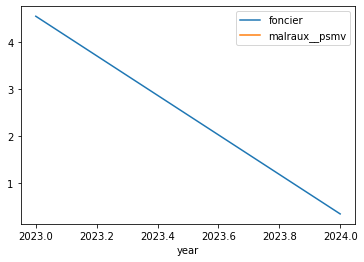

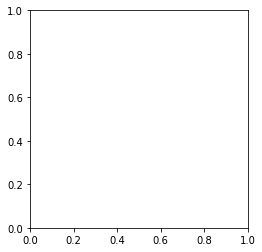

In [557]:
process_page("automatique")

In [473]:
#decomposer charges
#investissement

#Test 
#User/Widget Jupyternotebook 
    #Vérifier noteperiodes_simulation

#Global
    #CAGR of cashflow => net worth 
    #Rentabilité nette (%of revenus)

#Impôts
    #Vérifier montant impôts fonciers
    #


In [390]:
w= widgets.Dropdown(
    options=[('One', 1), ('Two', 2), ('Three', 3)],
    value=2,
    description='Number:',
)

In [252]:
w.options[0][1]

1